In [1]:
import helper.training_preprocess as tp
from helper.evaluator import Evaluator
from helper.trajectory import Trajectory
from models.stonesoup_radar_sim import StonesoupRadarSim
import numpy as np
import pickle
from tqdm import tqdm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

In [2]:
with open("../../dataset/dataframe-readins/full_traj_data.pkl", "rb") as f:
    test_traj_data = pickle.load(f)

In [3]:
def run_stonesoup_ekf_eval_pipeline(aTrajectory, aSim, anEvaluator, ifplot=False, ifshow=False, moe=False, filter_type="ekf"):
    test_radar_meas = aSim.simulate_radar_measurements(aTrajectory)
    
    if filter_type == "ekf":
        filter_tracks_list = aSim.run_ekf_filter(aTrajectory, test_radar_meas)
    elif filter_type == 'ukf':
        filter_tracks_list = aSim.run_ukf_filter(aTrajectory, test_radar_meas)
    
    converted_state_vecs, measurement_conversion_data = aSim.convert_radar_observations_to_cartesian(test_radar_meas)
    aTrajectory.set_converted_measurement_data(measurement_conversion_data)

    predicted_state_data, predicted_uncer_std_data = aSim.process_stonesoup_tracker_info(filter_tracks_list)
    full_pos_states, full_pos_covs = aSim.gather_position_prediction_info(filter_tracks_list) # for numerical eval
    
    if ifplot:
        aTrajectory.visualize_truth_versus_measurement()
        aTrajectory.visualize_truth_versus_filter(predicted_state_data, predicted_uncer_std_data)
        
    outData = {}
    if moe:
        full_truth_pos = np.column_stack((aTrajectory.truth_x[1:], aTrajectory.truth_y[1:], aTrajectory.truth_z[1:]))
        outData['PredErrAvg'] = anEvaluator.calculate_3d_avg_euclid_error(aTrajectory.truth_x[1:], aTrajectory.truth_y[1:], aTrajectory.truth_z[1:], predicted_state_data['x'], predicted_state_data['y'], predicted_state_data['z'])
    else:
        full_truth_pos = np.column_stack((aTrajectory.orig_truth_x[1:], aTrajectory.orig_truth_y[1:], aTrajectory.orig_truth_z[1:]))
        outData['PredErrAvg'] = anEvaluator.calculate_3d_avg_euclid_error(aTrajectory.orig_truth_x[1:], aTrajectory.orig_truth_y[1:], aTrajectory.orig_truth_z[1:], predicted_state_data['x'],predicted_state_data['y'], predicted_state_data['z'])
    
    full_meas_pos = np.column_stack((measurement_conversion_data['x'][1:], measurement_conversion_data['y'][1:], measurement_conversion_data['z'][1:]))
    
    outData['MeasErrAvg'] = anEvaluator.calculate_3d_avg_euclid_error(aTrajectory.truth_x[1:], aTrajectory.truth_y[1:], aTrajectory.truth_z[1:], measurement_conversion_data['x'][1:], measurement_conversion_data['y'][1:], measurement_conversion_data['z'][1:])
    
    outData['MDAvg'] = anEvaluator.average_mahalanobis_distance(full_pos_states, full_pos_covs, full_truth_pos)
    outData['DeterminantAvg'] = anEvaluator.compute_average_determinant(full_pos_covs)
    outData['TraceAvg'] = anEvaluator.compute_average_covariance_trace(full_pos_covs)
    
    if ifshow:
        print(f"Average Filter Error: {outData['PredErrAvg']}")
        print(f"Average Measurement Error: {outData['MeasErrAvg']}")
        print(f"Average Filter Trace: {outData['TraceAvg']}")
        print(f"Average Filter MD: {outData['MDAvg']}")
        print(f"Average Filter Determinant: {outData['DeterminantAvg']}")
    return outData, aTrajectory

In [4]:
def store_truth_data(aDF):
    truth_data = {}
    truth_data['timestamps'] = np.array(aDF['timestamp'])
    truth_data['x'] = np.array(aDF['tx'])
    truth_data['y'] = np.array(aDF['ty'])
    truth_data['z'] = np.array(aDF['tz'])
    truth_data['vx'] = np.array(aDF['vx'])
    truth_data['vy'] = np.array(aDF['vy'])
    truth_data['vz'] = np.array(aDF['vz'])
    return truth_data

## Single Traj EKF Pipeline Testing

In [5]:
# Measurement Simulation Inputs
moe = True 
traj_no = 1
test_traj_df = test_traj_data[traj_no]
display(test_traj_df)
truth_data = store_truth_data(test_traj_df)

,timestamp,tx,ty,tz,vx,vy,vz,delta_time
0,0.000000,-0.295912,-34.319134,18.547798,0.728622,-3.276935,0.035605,0.100000
1,0.100000,-0.223050,-34.646827,18.551359,0.614757,-2.530491,0.141263,0.100000
2,0.200000,-0.161574,-34.899876,18.565485,0.916700,-2.263460,0.211632,0.100000
3,0.300000,-0.069905,-35.126222,18.586648,1.174451,-1.594109,0.226630,0.100000
4,0.400000,0.047540,-35.285632,18.609311,1.603769,-1.135005,0.241438,0.100000
...,...,...,...,...,...,...,...,...
128,12.799988,-2.359200,-37.446620,18.686063,0.018841,-2.733525,0.050074,0.100000
129,12.899988,-2.357316,-37.719974,18.691071,0.266043,-2.904970,0.072446,0.099999
130,12.999988,-2.330712,-38.010469,18.698315,0.418804,-2.649930,0.069750,0.099999
131,13.099987,-2.288832,-38.275461,18.705290,0.624692,-2.841576,0.030310,0.100000


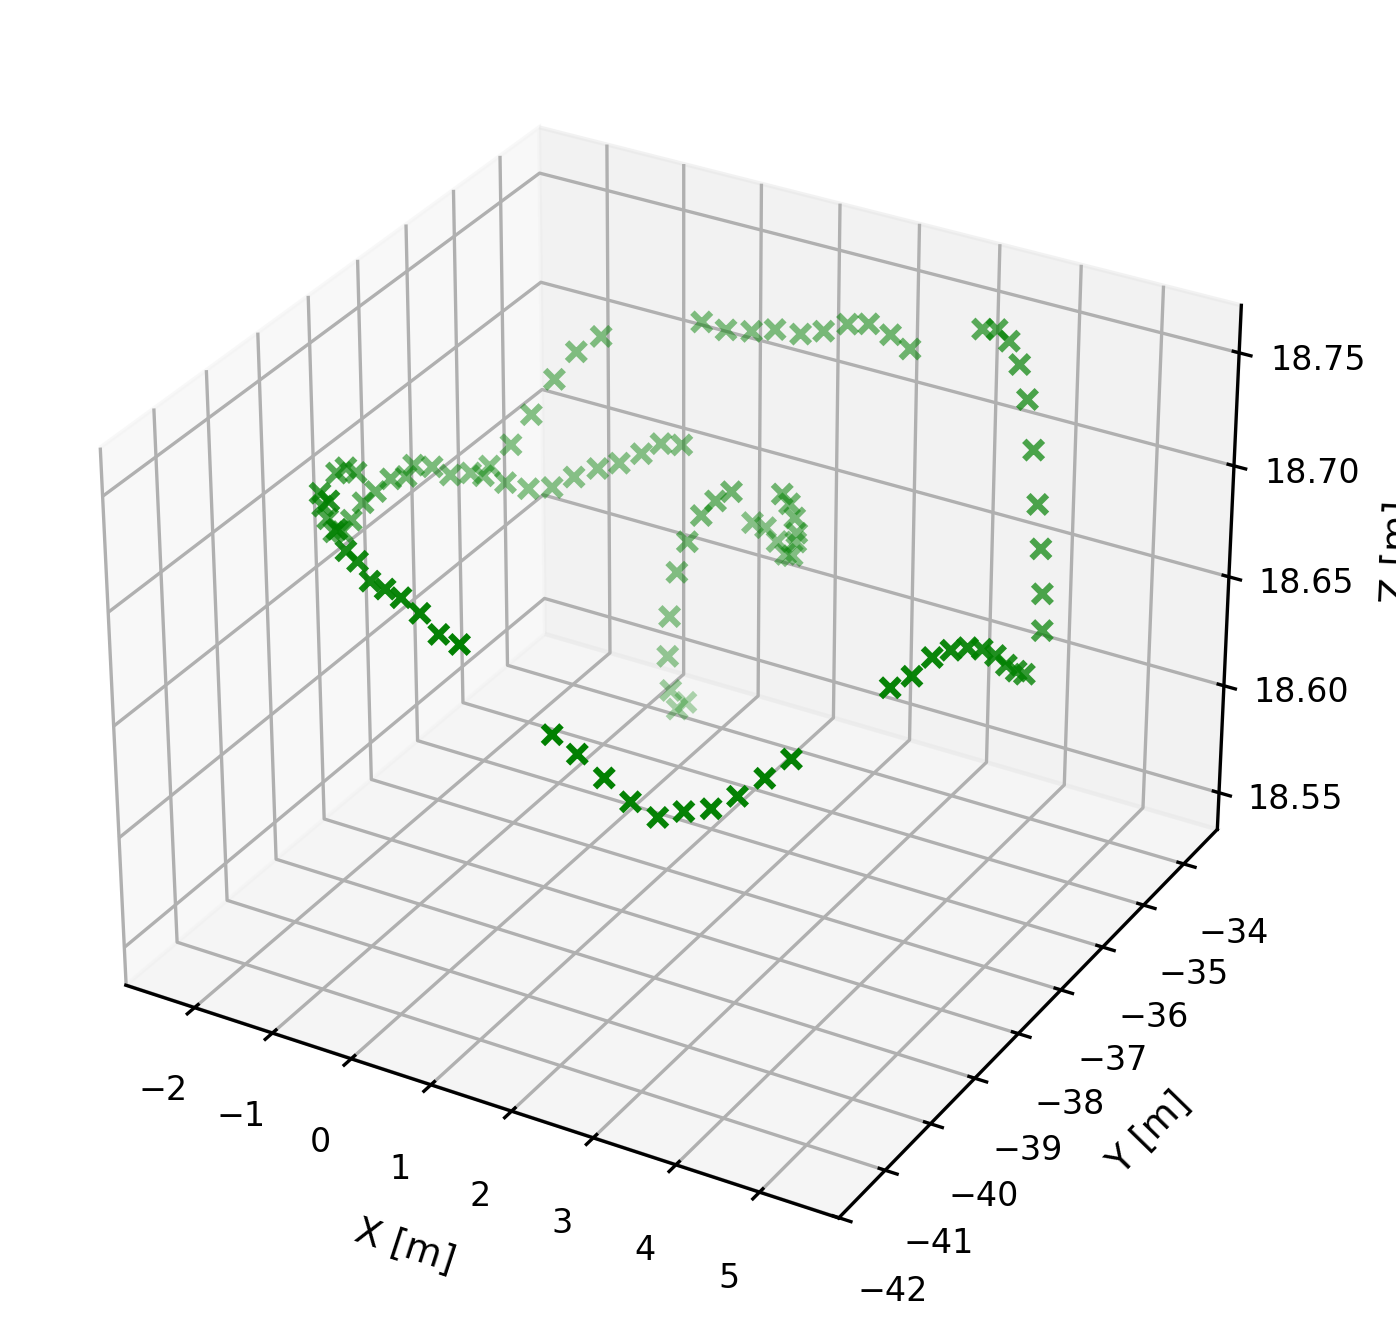

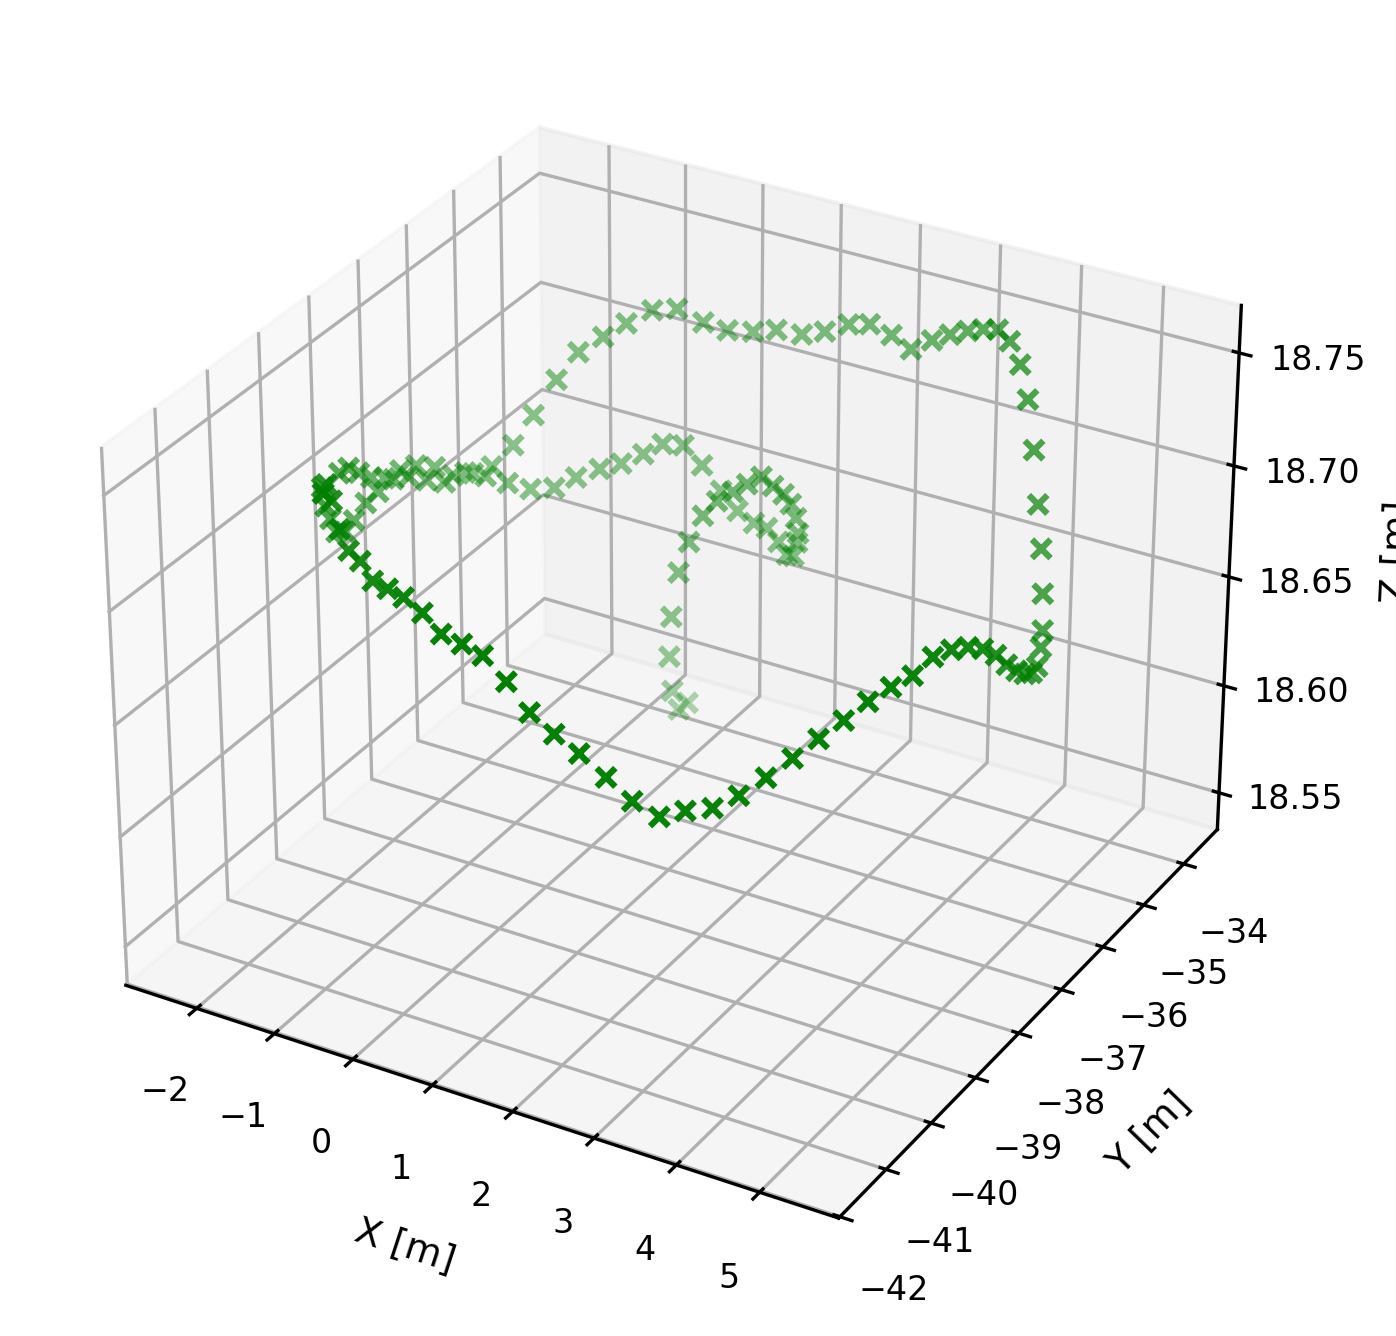

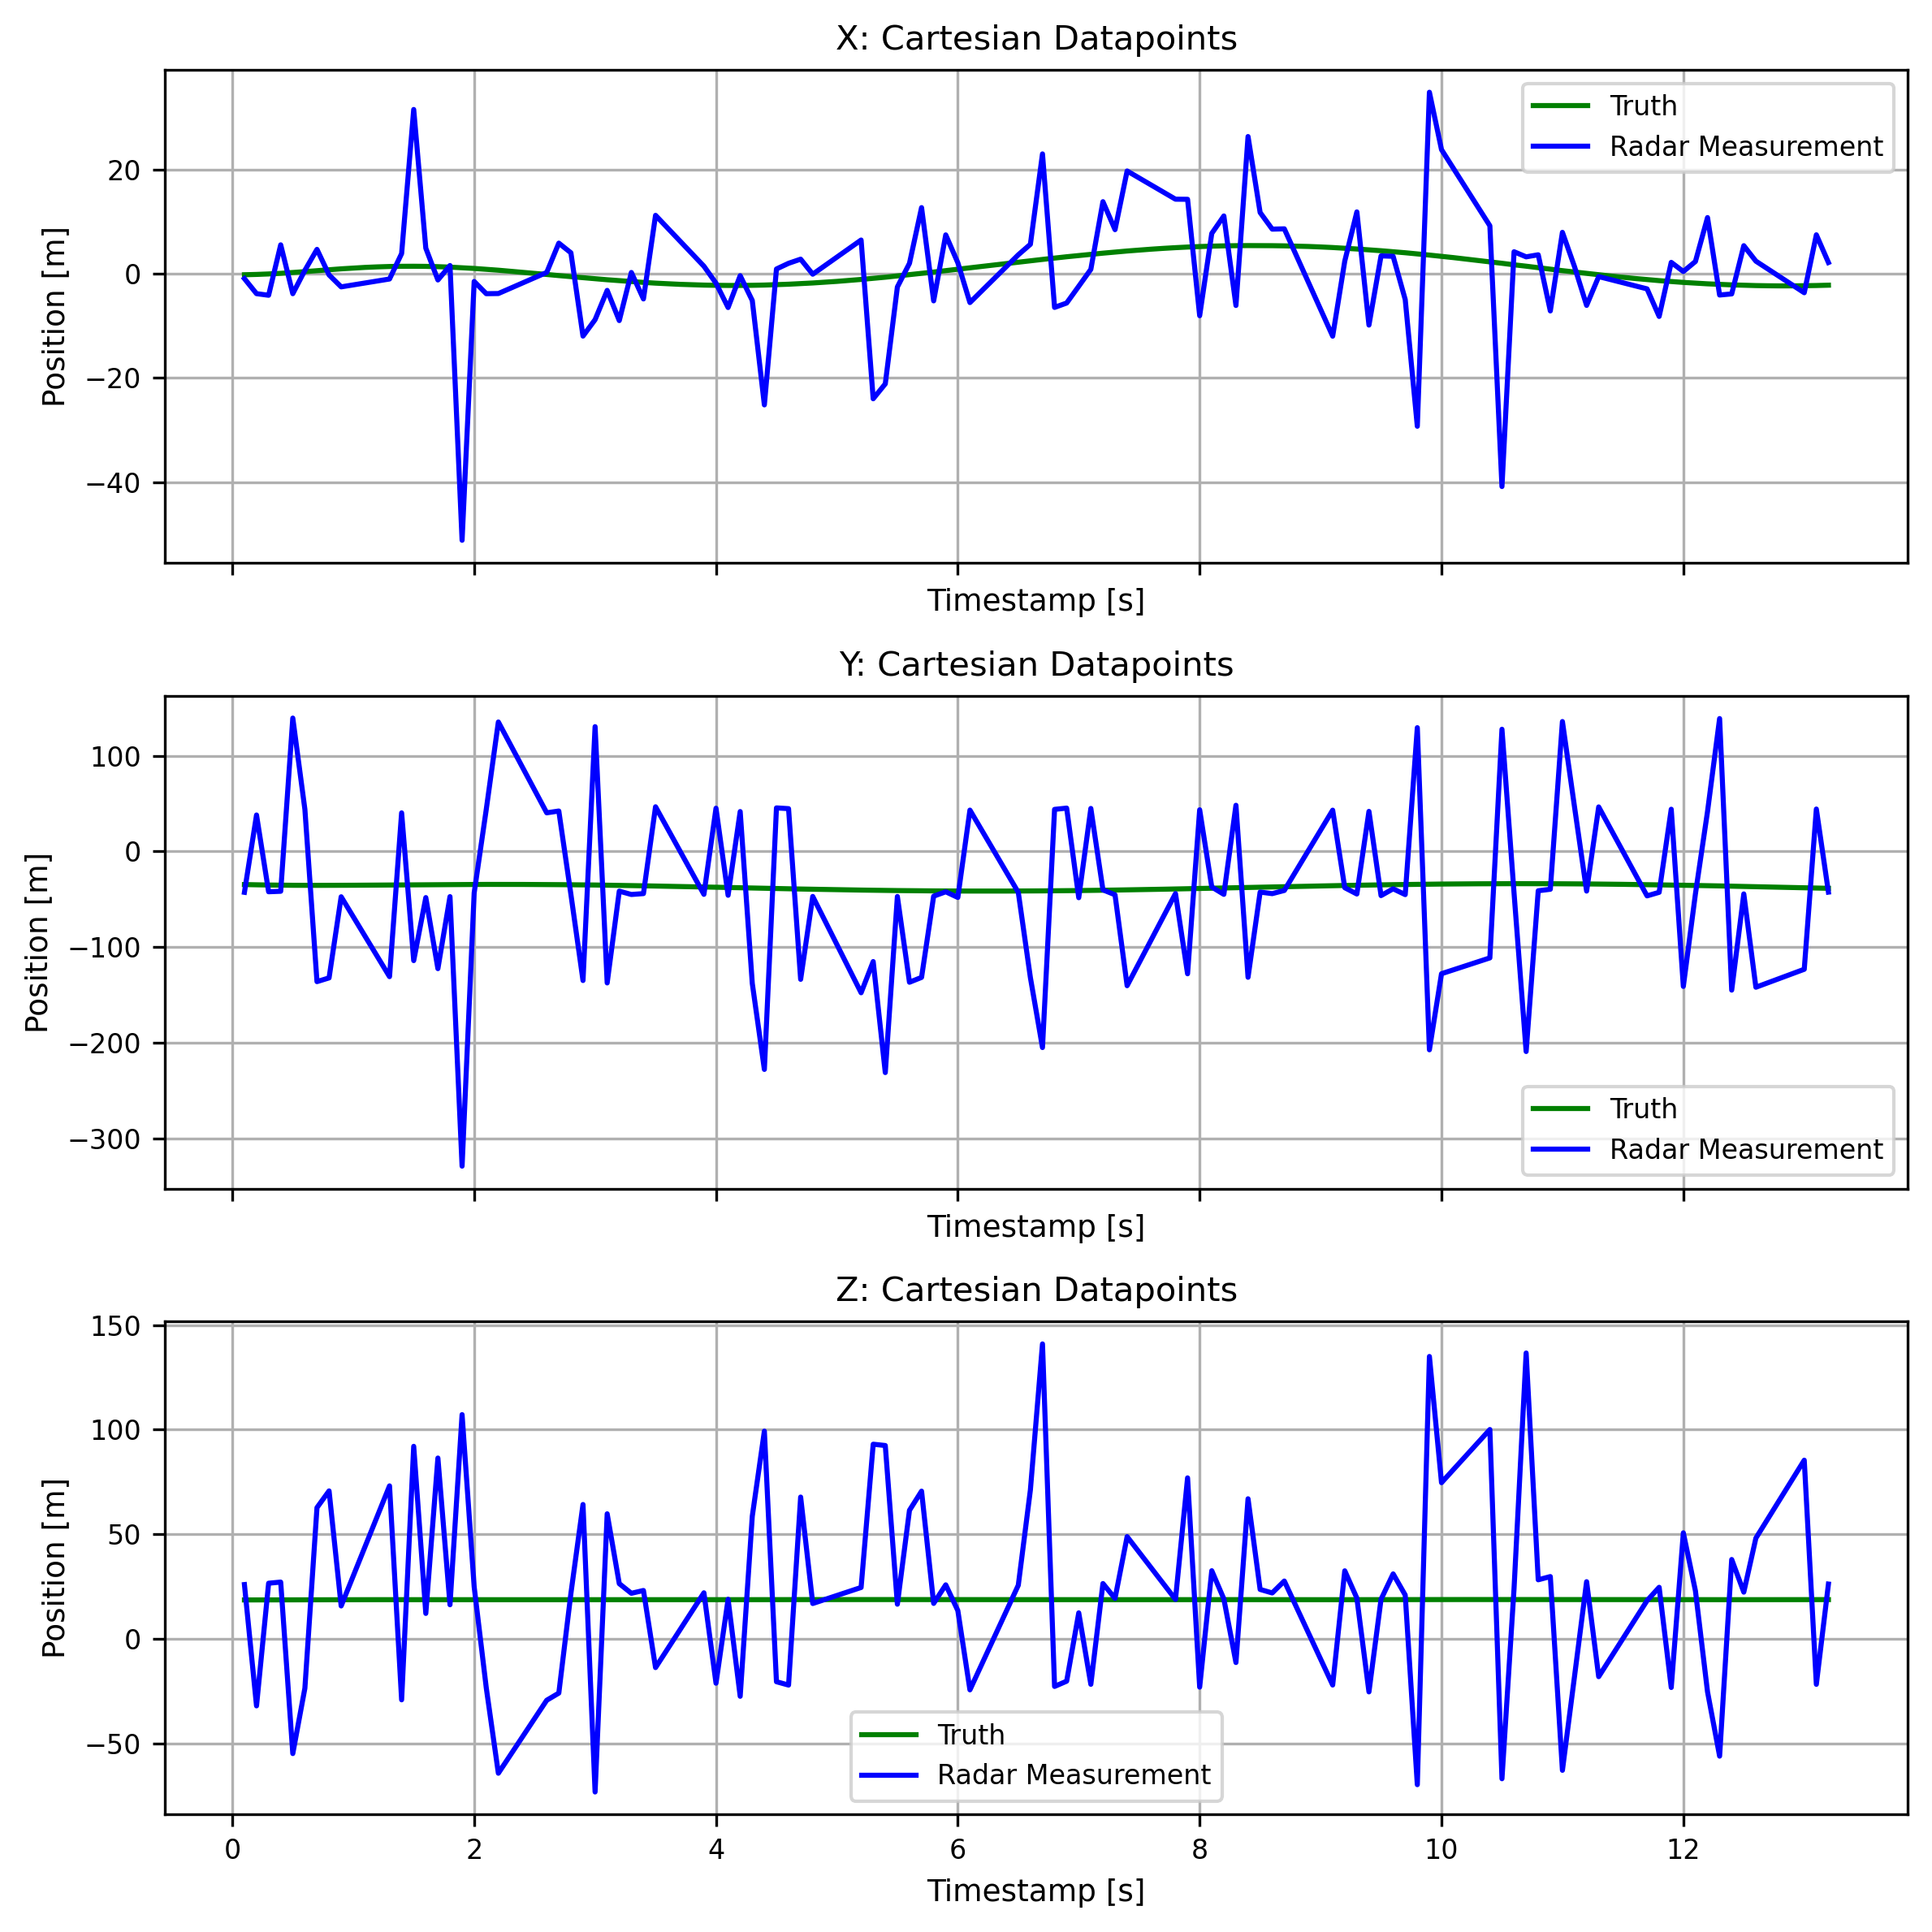

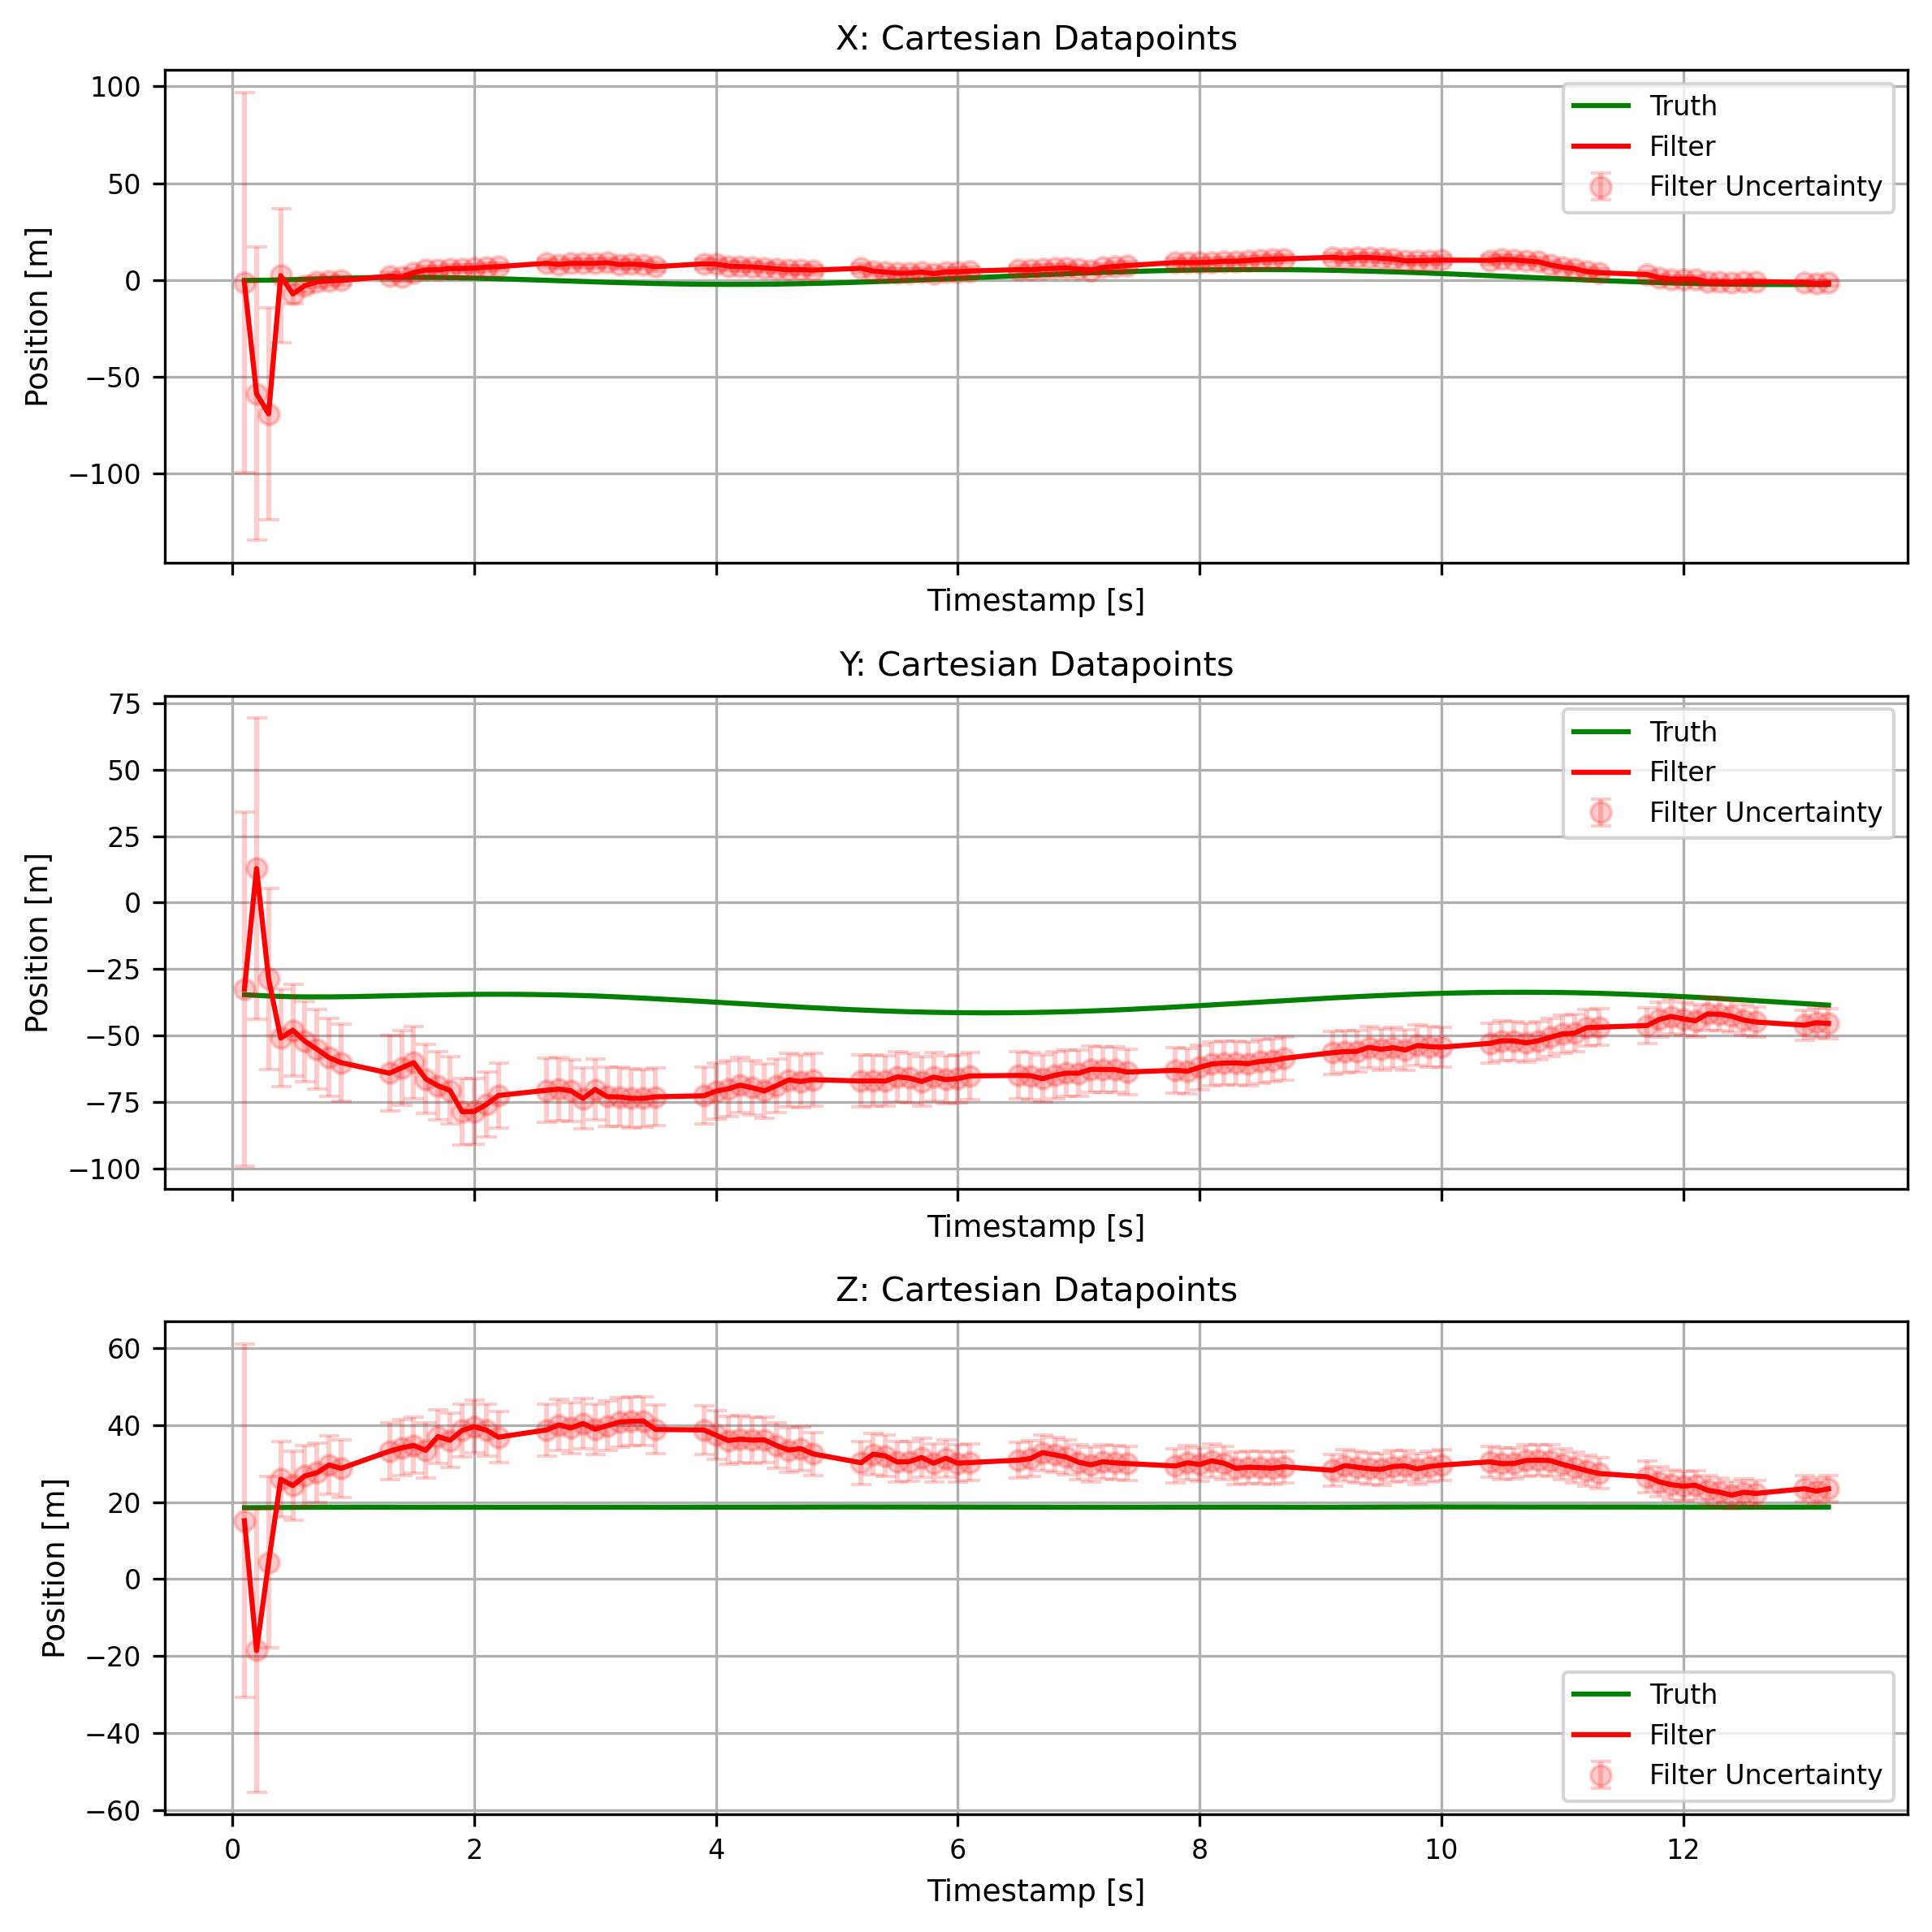

Average Filter Error: 27.96882487360512
Average Measurement Error: 77.37764407207116
Average Filter Trace: 442.2713458124078
Average Filter MD: 2.952478558521047
Average Filter Determinant: 3873.109908519656
CPU times: total: 1.5 s
Wall time: 2.66 s


In [11]:
%%time
TestTraj = Trajectory(truth_data, 1, measurement_only_eval=moe)
TestTraj.apply_sampling_gaps(remove_pct=25)
TestSim = StonesoupRadarSim(proc_noise=0.1, sensor_noise_level='high', include_range_rate=True)
TestEval = Evaluator()
TestTraj.visualize_3d_scatter()
TestTraj.visualize_3d_scatter(orig=True)
out, altered_traj = run_stonesoup_ekf_eval_pipeline(TestTraj, TestSim, TestEval, ifplot=True, ifshow=True, moe=moe, filter_type="ukf")

## HoltWinters Radar Resolve

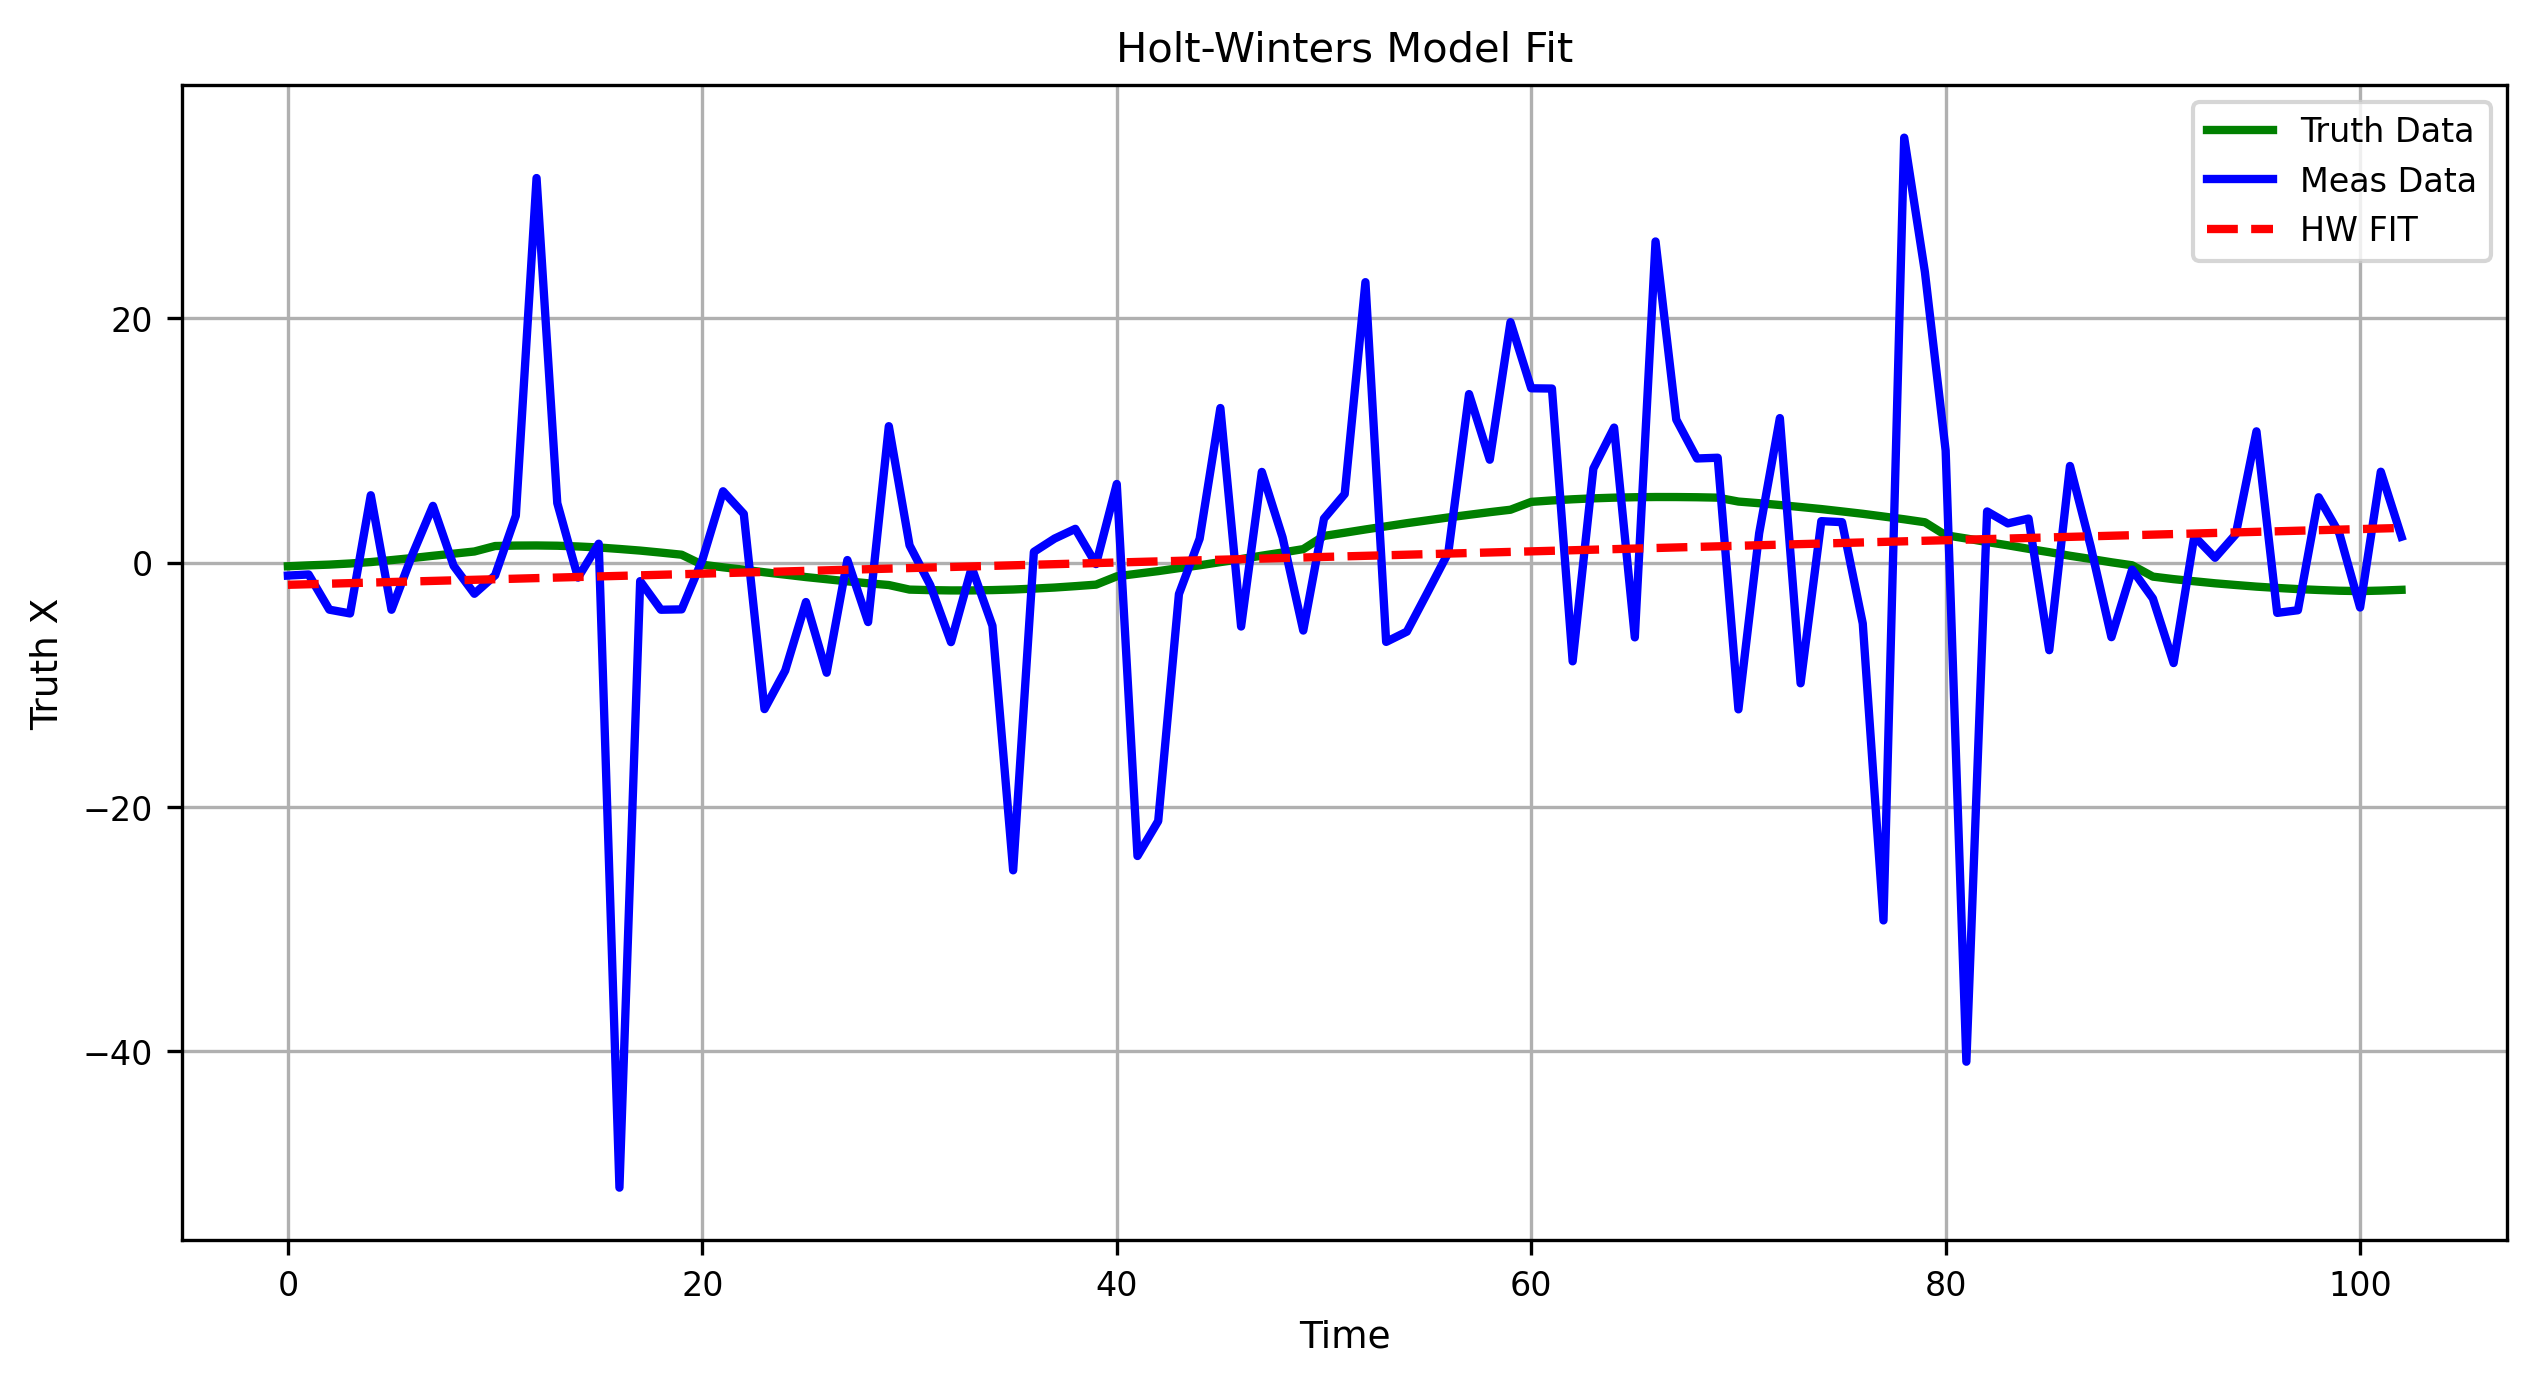

Holt Winters x Error: 2.2948438836692366
Meas x Error: 7.514670269398316


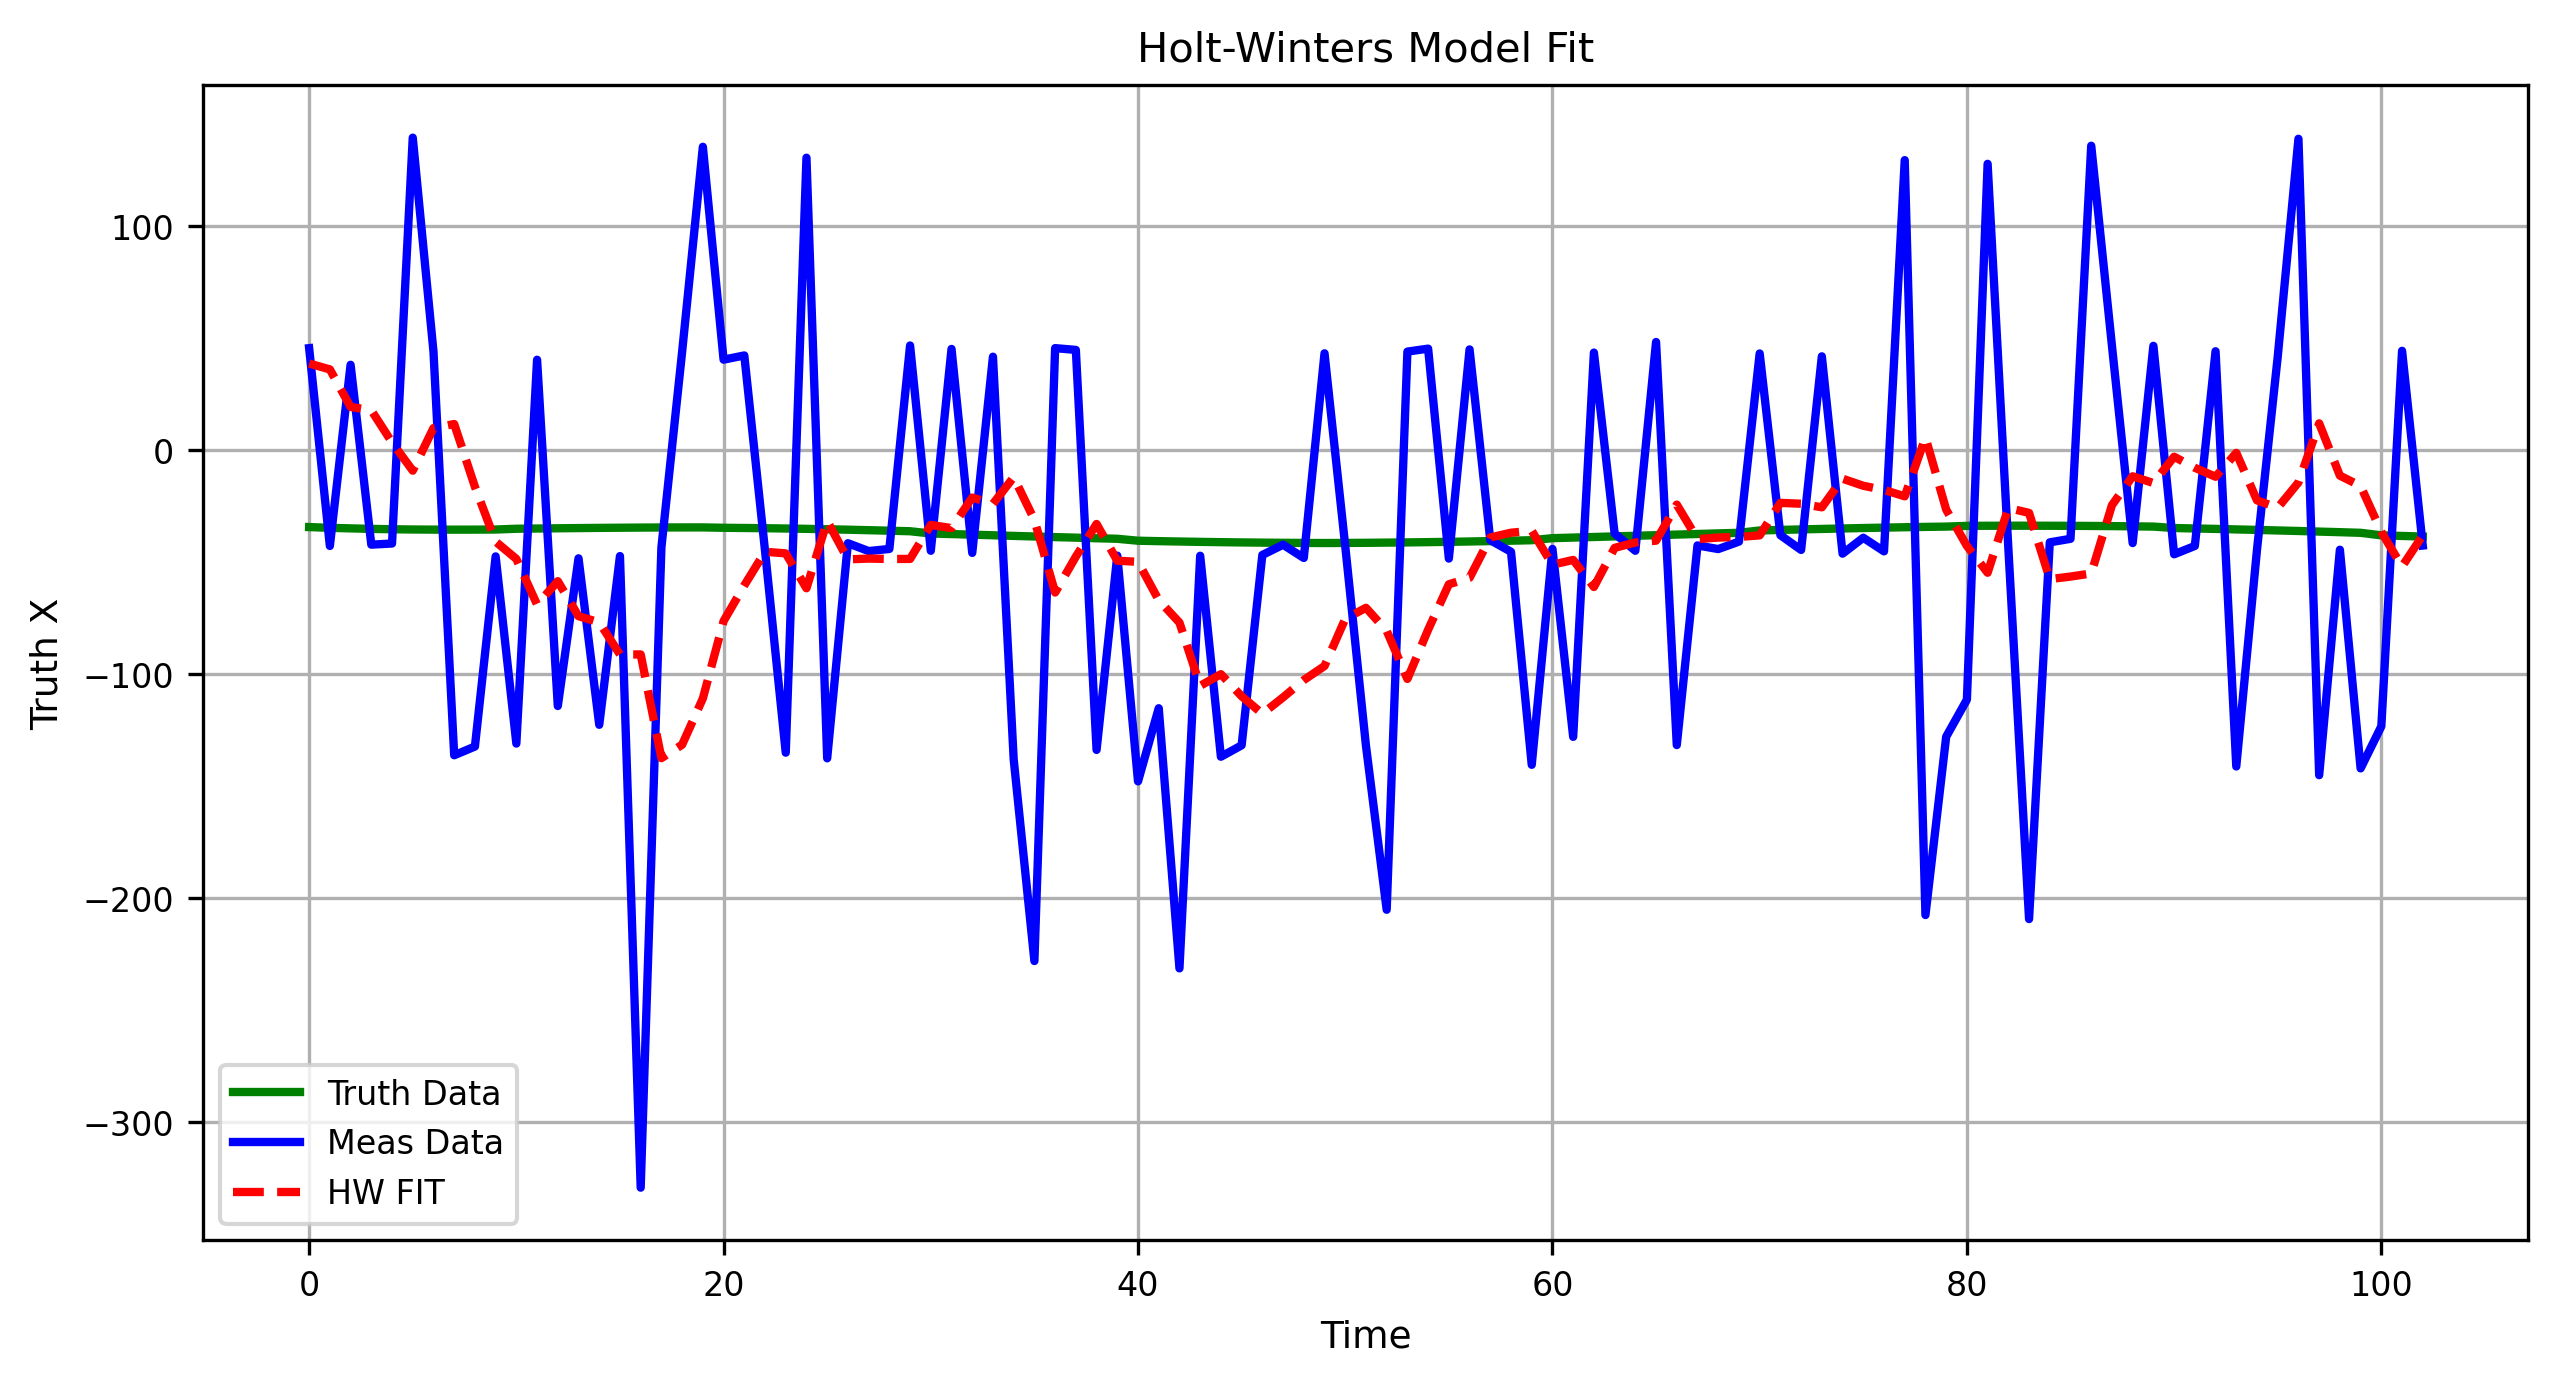

Holt Winters y Error: 26.214873820169935
Meas y Error: 66.59756453697699


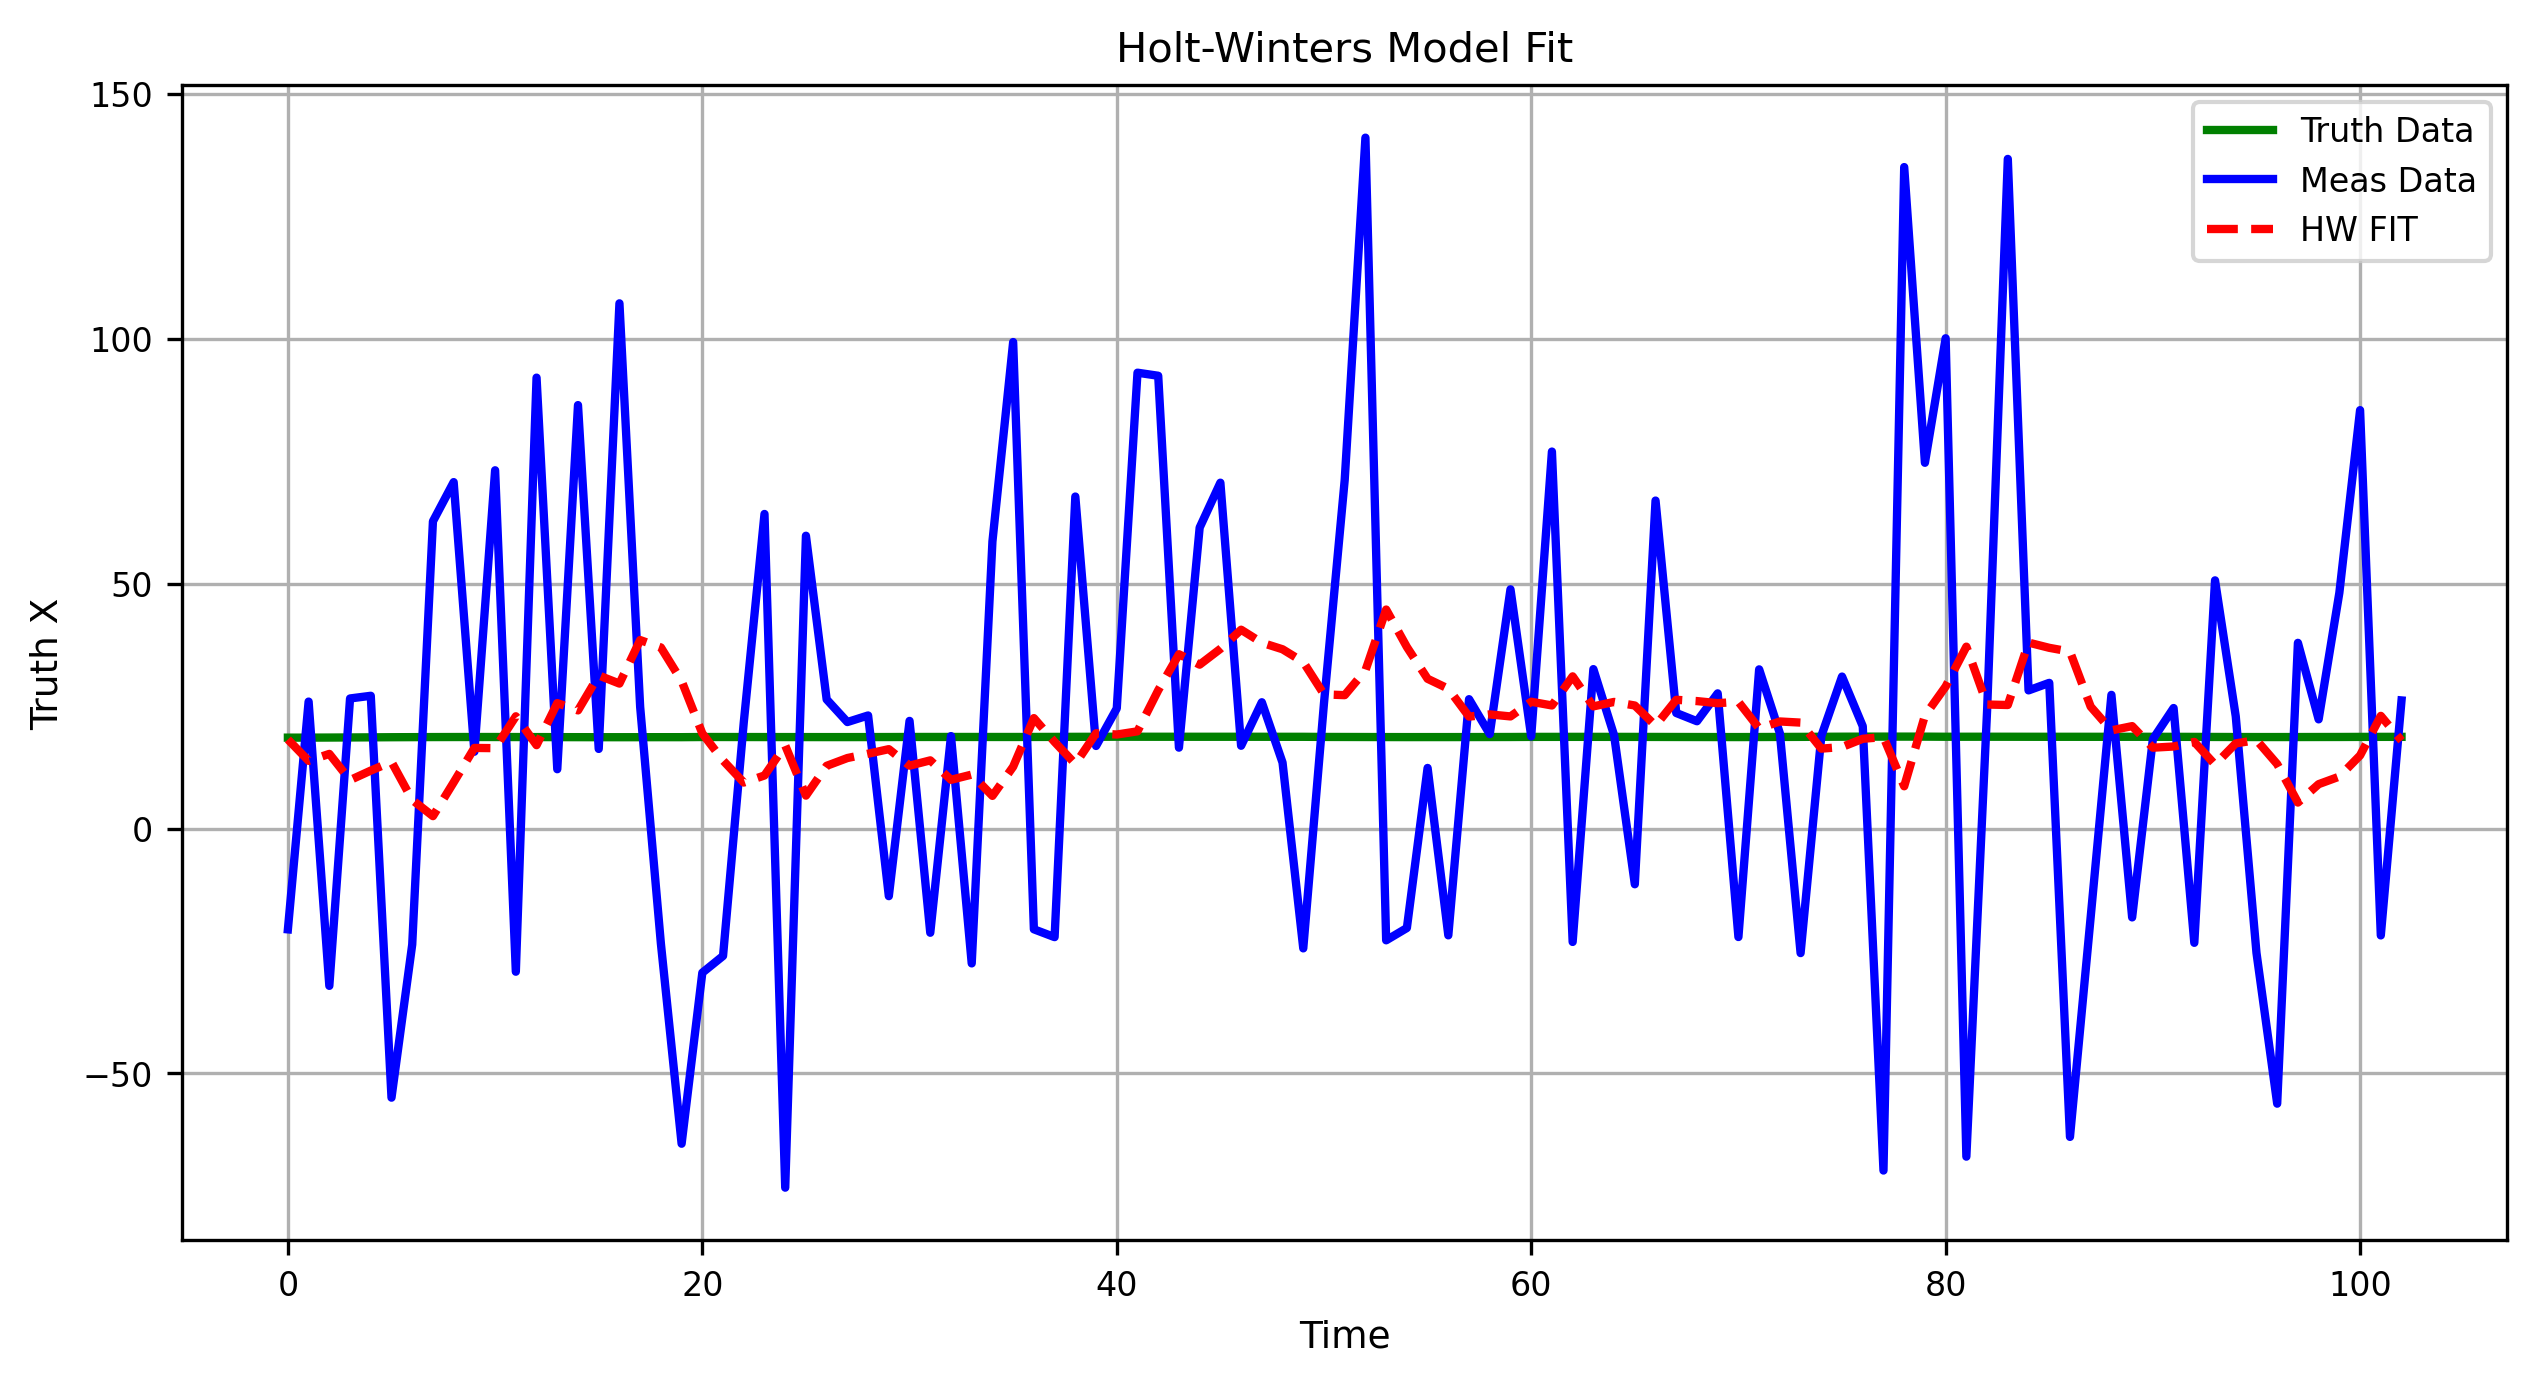

Holt Winters z Error: 7.622833157667487
Meas z Error: 34.45361921125289


OVERALL HW ERR: 28.37125155016945
OVERALL MEASUREMENT ERR: 76.89373436851683


In [12]:
axes = ['x', 'y', 'z']
hw_pred = {}
for axe in axes:
    if axe == 'x':
        meas = np.array(altered_traj.measured_x)
        truth = np.array(altered_traj.truth_x)
    elif axe == 'y':
        meas = np.array(altered_traj.measured_y)
        truth = np.array(altered_traj.truth_y)
    elif axe == 'z':
        meas = np.array(altered_traj.measured_z)
        truth = np.array(altered_traj.truth_z)
        
    time_steps = np.arange(len(truth))
    model = ExponentialSmoothing(meas, trend="add")
    fit_model = model.fit()
    
    plt.figure(figsize=(10, 5))
    plt.plot(time_steps, truth, label="Truth Data", color="green", linewidth=2)
    plt.plot(time_steps, meas, label="Meas Data", color="blue", linewidth=2)
    plt.plot(time_steps, fit_model.fittedvalues, label="HW FIT", color="red", linestyle="dashed", linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("Truth X")
    plt.legend()
    plt.title("Holt-Winters Model Fit")
    plt.grid()
    plt.show()
    
    hw_pred[axe] = fit_model.fittedvalues
    
    N = len(truth)
    print(f"Holt Winters {axe} Error: {TestEval.calculate_3d_avg_euclid_error(truth, np.zeros(N), np.zeros(N), fit_model.fittedvalues, np.zeros(N), np.zeros(N))}")
    print(f"Meas {axe} Error: {TestEval.calculate_3d_avg_euclid_error(truth, np.zeros(N), np.zeros(N), meas, np.zeros(N), np.zeros(N))}")

print("\n")
print(f"OVERALL HW ERR: {TestEval.calculate_3d_avg_euclid_error(np.array(altered_traj.truth_x), np.array(altered_traj.truth_y), np.array(altered_traj.truth_z), hw_pred['x'], hw_pred['y'], hw_pred['z'])}")

print(f"OVERALL MEASUREMENT ERR: {TestEval.calculate_3d_avg_euclid_error(np.array(altered_traj.truth_x), np.array(altered_traj.truth_y), np.array(altered_traj.truth_z), altered_traj.measured_x, altered_traj.measured_y, altered_traj.measured_z)}")

## Holt Winters Truth Forecasting

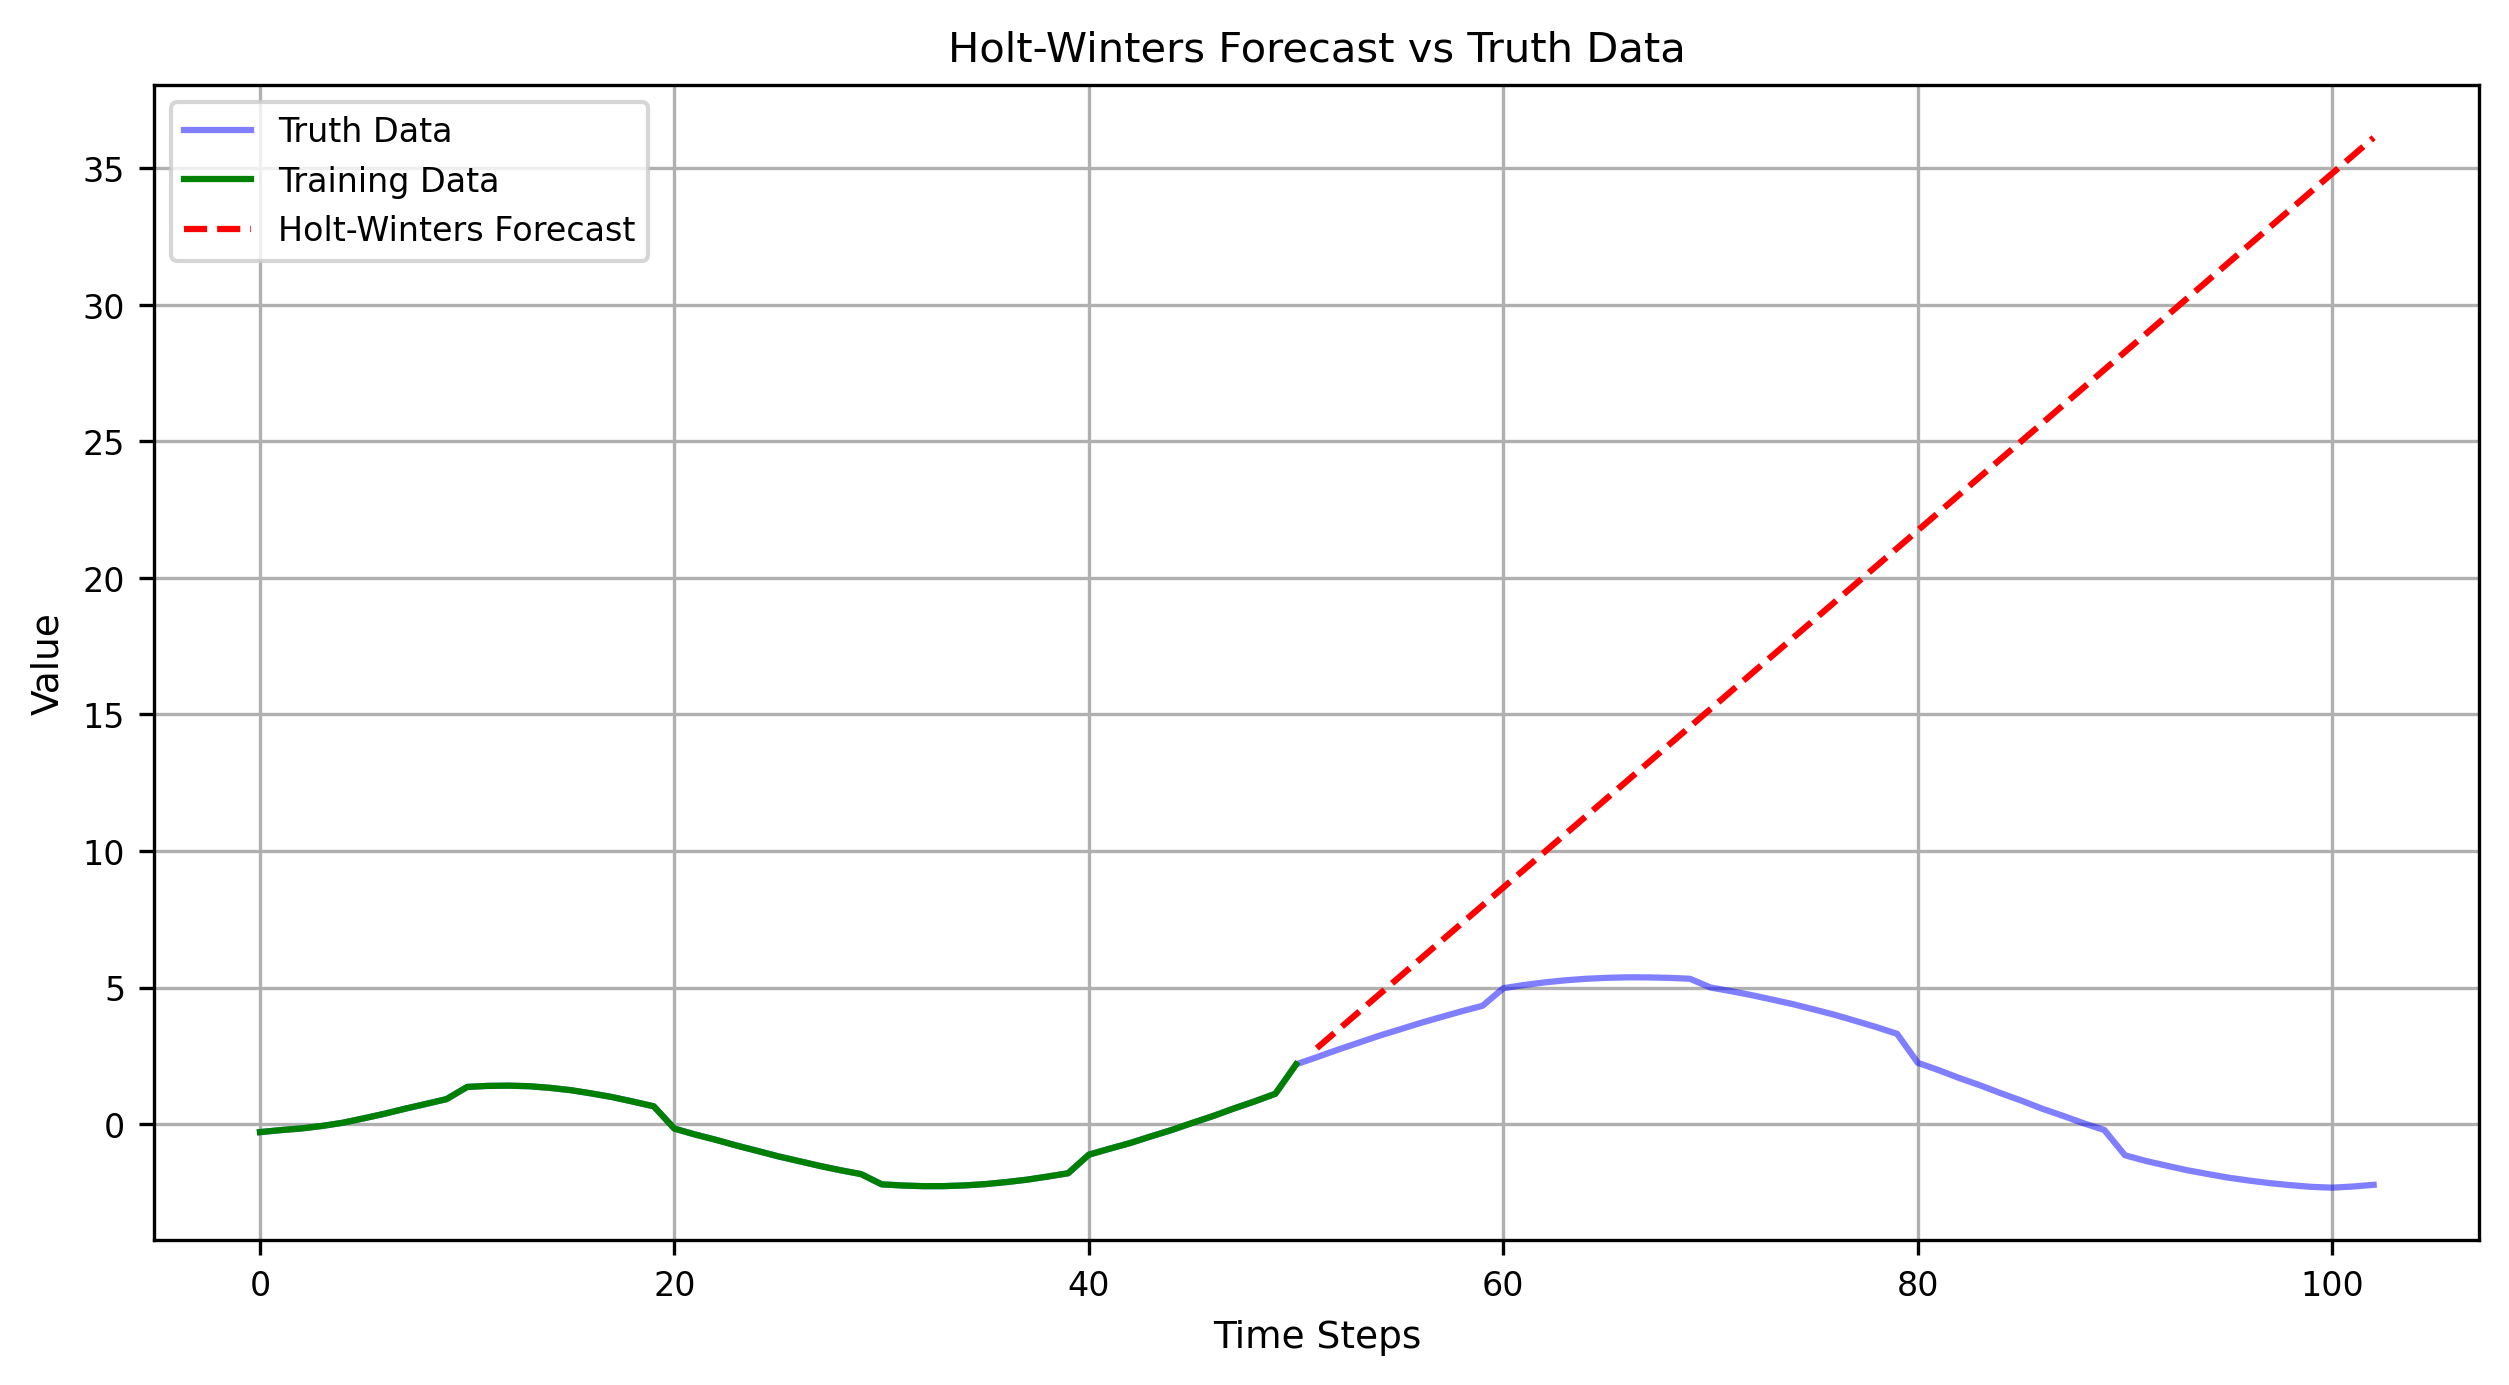

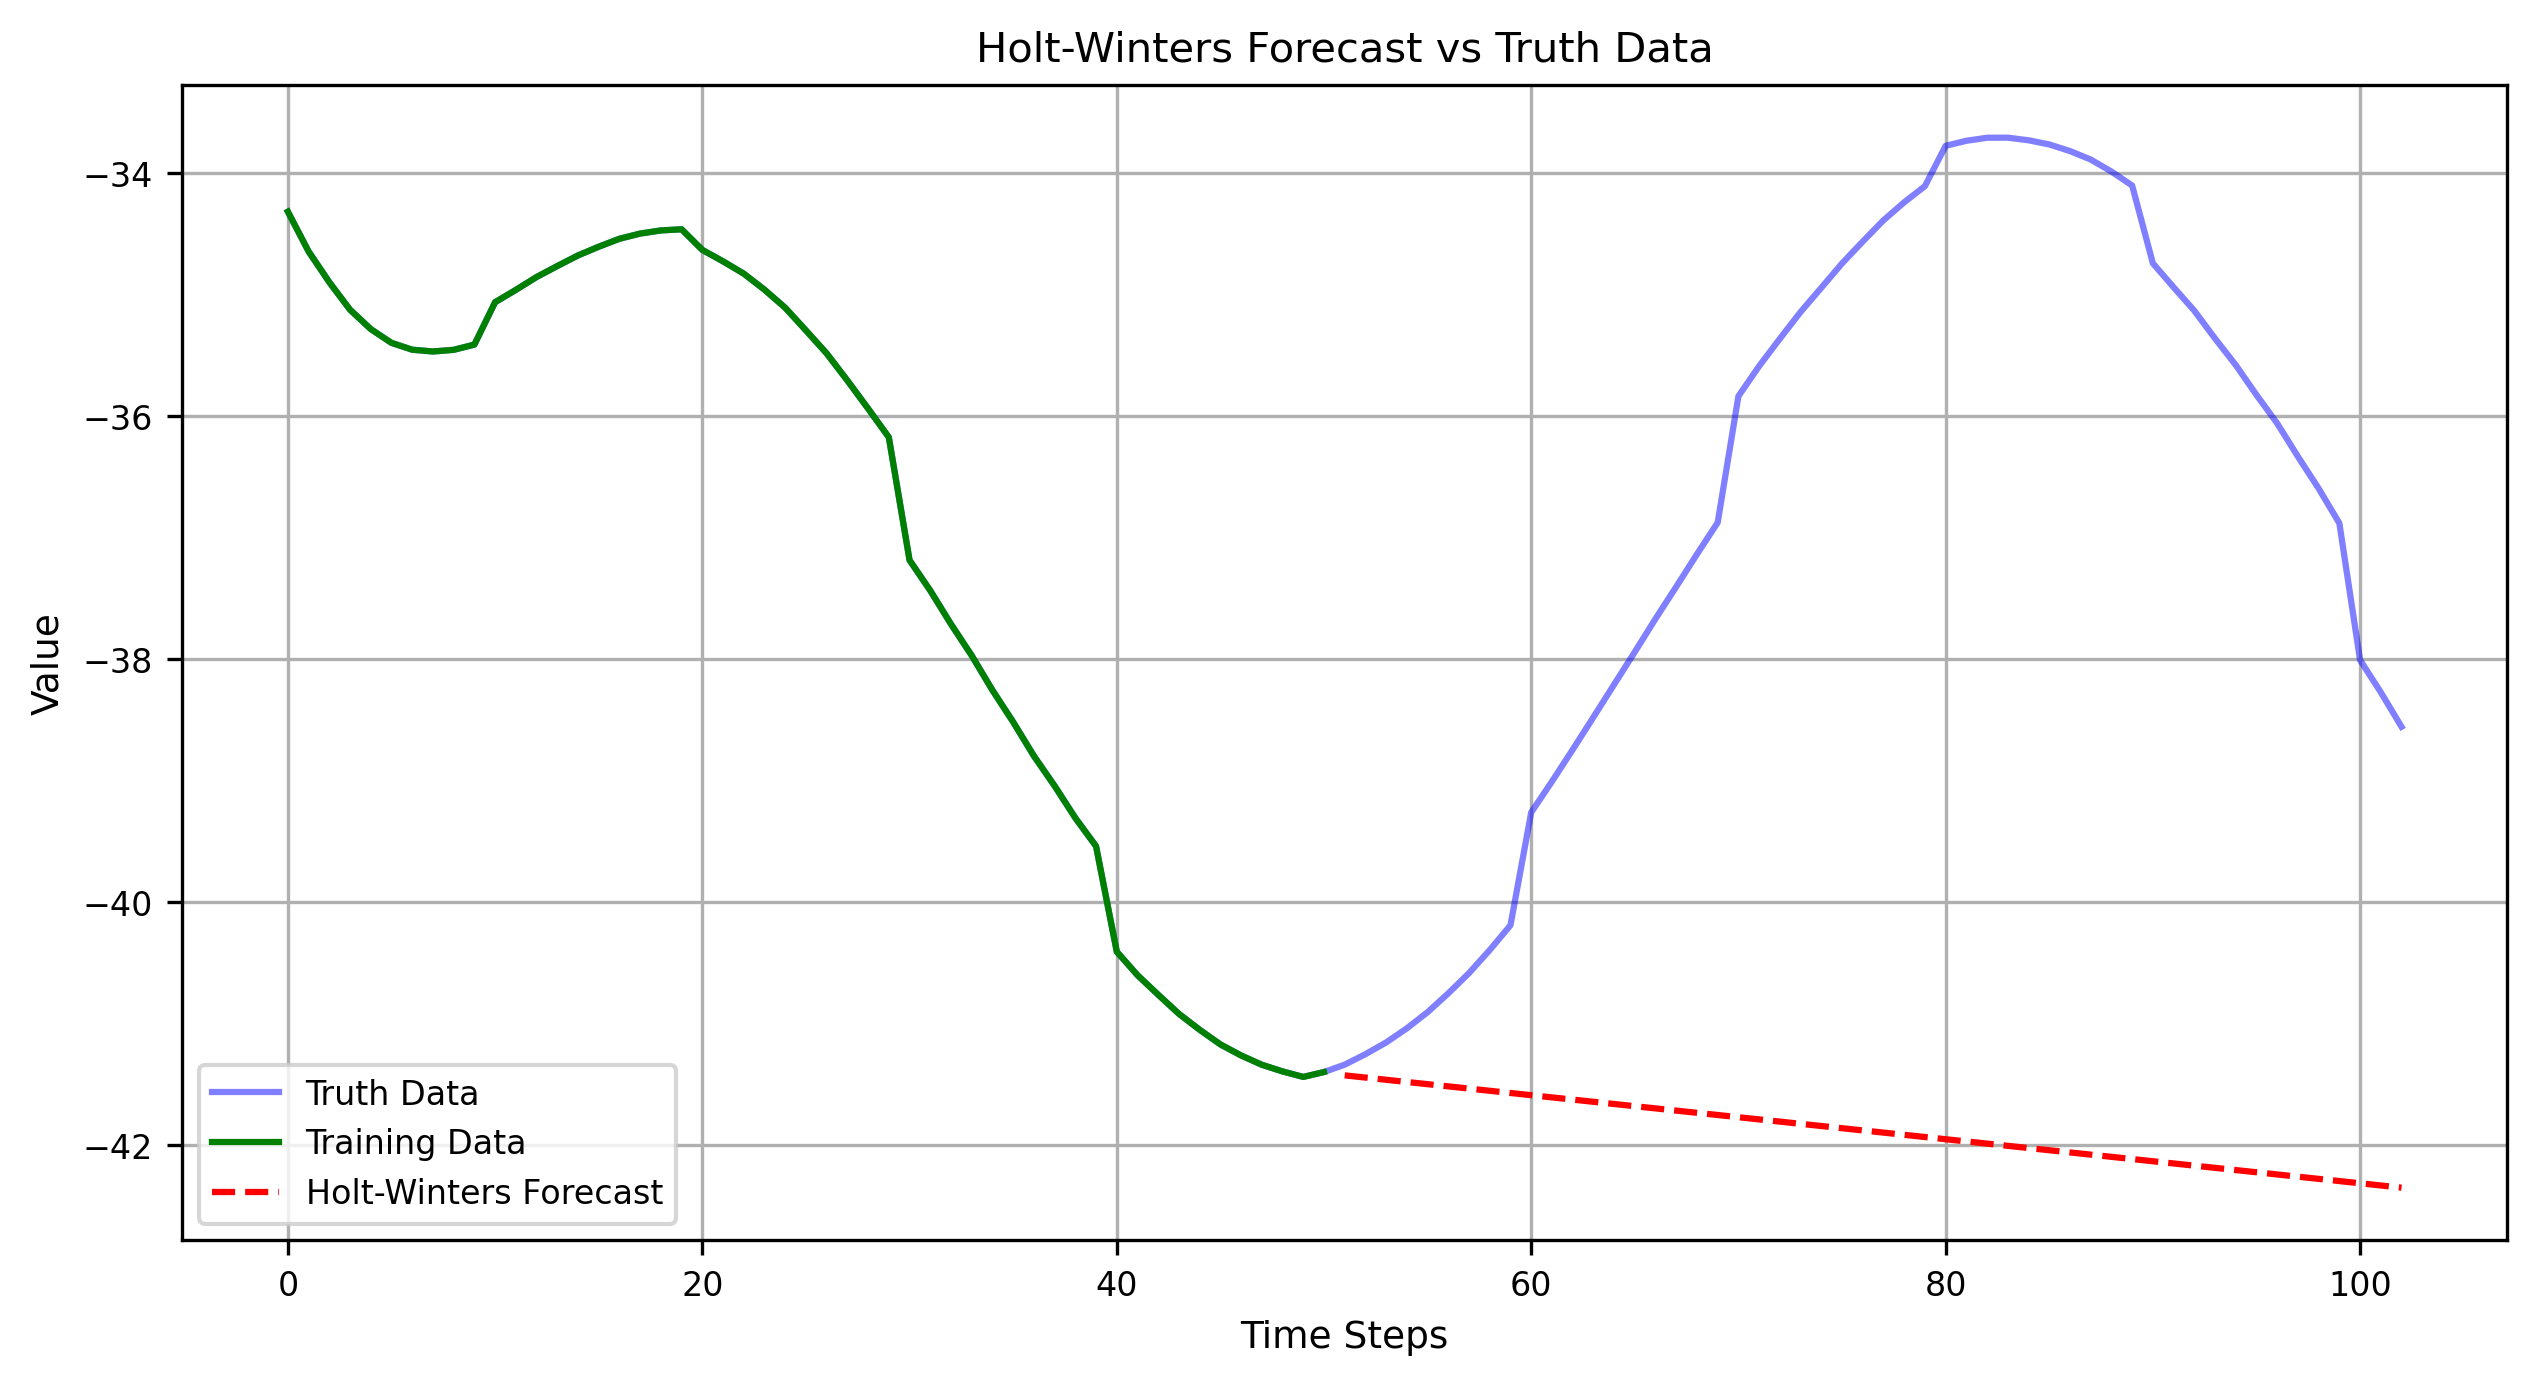

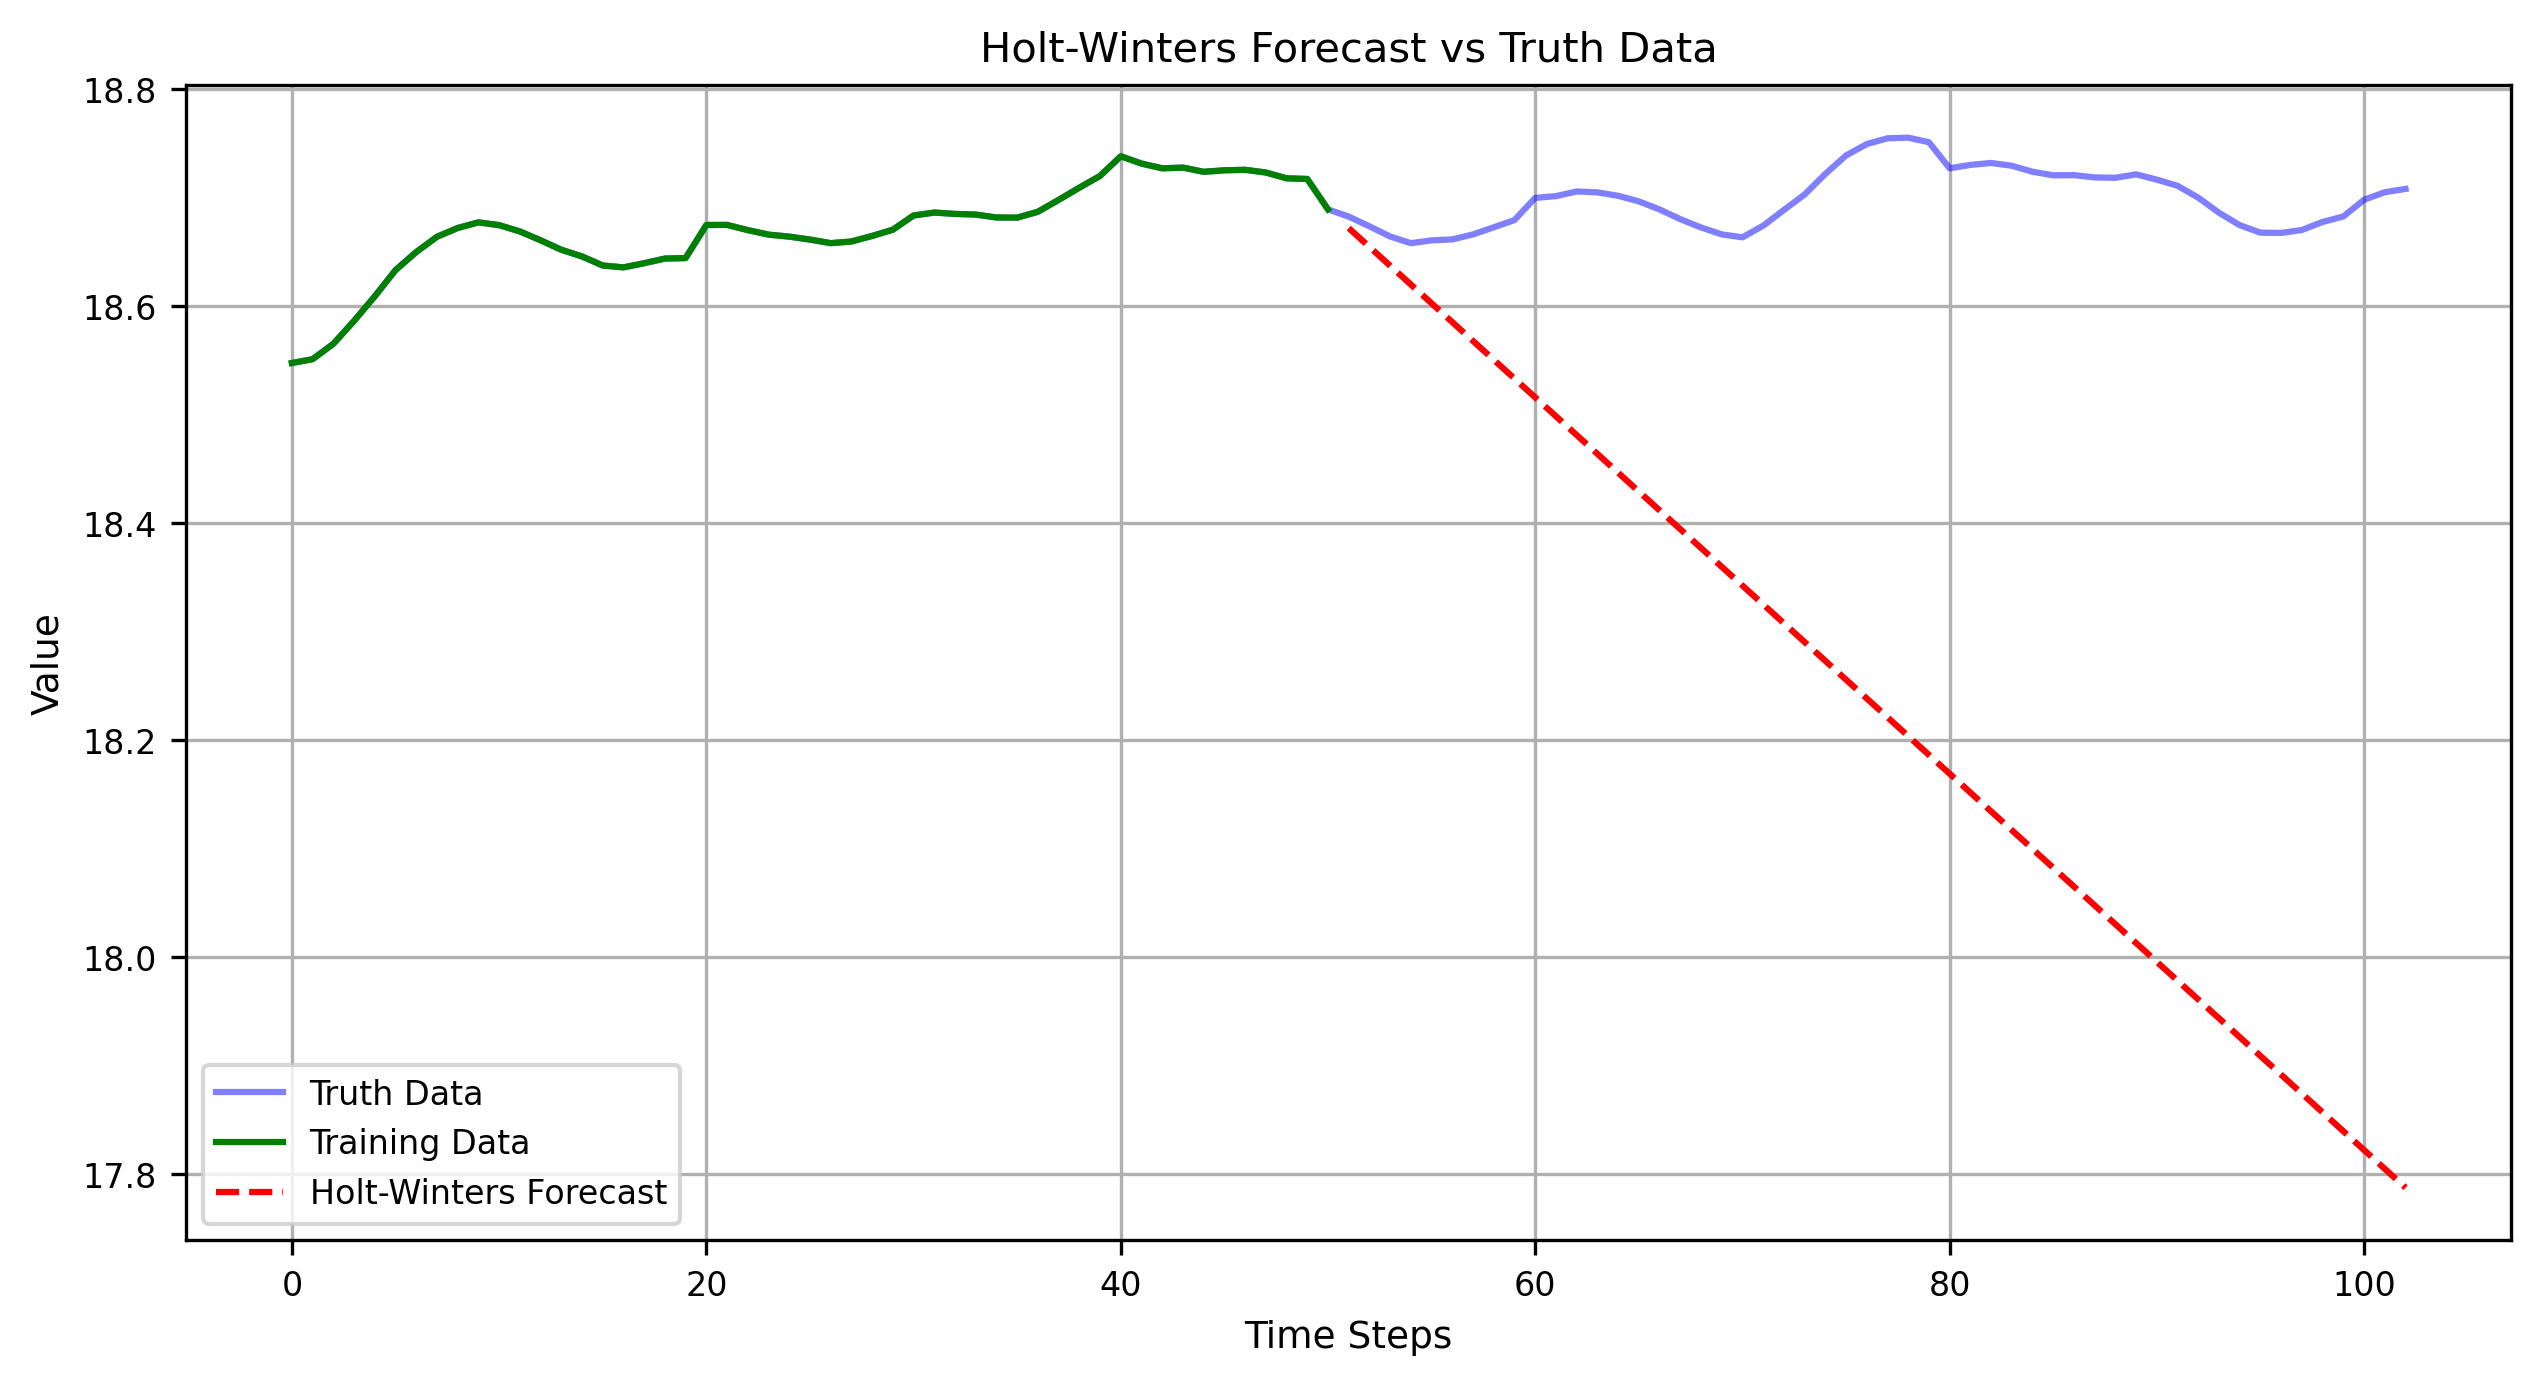

In [13]:
axes = ['x', 'y', 'z']
for axe in axes:
    if axe == 'x':
        truth = np.array(altered_traj.truth_x)
    elif axe == 'y':
        truth = np.array(altered_traj.truth_y)
    elif axe == 'z':
        truth = np.array(altered_traj.truth_z)
        
    split_idx = len(truth) // 2
    train_data = truth[:split_idx]
    test_data = truth[split_idx:]
    
    hw_model = ExponentialSmoothing(train_data, trend='add')
    hw_fit = hw_model.fit()
    forecast = hw_fit.forecast(len(test_data))
    
    plt.figure(figsize=(10, 5))
    plt.plot(truth, label="Truth Data", color="blue", alpha=0.5)
    plt.plot(range(split_idx), train_data, label="Training Data", color="green")
    plt.plot(range(split_idx, len(truth)), forecast, label="Holt-Winters Forecast", color="red", linestyle="dashed")
    plt.legend()
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.title("Holt-Winters Forecast vs Truth Data")
    plt.grid()
    plt.show()

## BATCH EKF

In [23]:
def eval_batch_ekf(aTrajDict, aTestSim, aSample_rmv_percent=0, moe=False, filter_type="ekf"):
    aTestEval = Evaluator()
    filter_mds = []
    filter_errs = []
    filter_traces = []
    filter_dets = []
    meas_errs = []
    for traj_no_idx, traj_df in aTrajDict.items():
        temp_truth_data = store_truth_data(traj_df)
        temp_traj = Trajectory(temp_truth_data, traj_no_idx, measurement_only_eval=moe)
        temp_traj.apply_sampling_gaps(remove_pct=aSample_rmv_percent)
        pipe_out, none = run_stonesoup_ekf_eval_pipeline(temp_traj, aTestSim, aTestEval, ifplot=False, ifshow=False, moe=moe, filter_type=filter_type)
        
        if np.isnan(pipe_out['PredErrAvg']):
            print(f"Skipping ED: {pipe_out['PredErrAvg']}, TRAJ NO: {traj_no_idx}")
            continue
        
        if np.isnan(pipe_out['MDAvg']):
            print(f"Skipping MD: {pipe_out['MDAvg']}, TRAJ NO: {traj_no_idx}")
            continue
            
        if np.isnan(pipe_out['DeterminantAvg']):
            print(f"Skipping DET: {pipe_out['DeterminantAvg']}, TRAJ NO: {traj_no_idx}")
            continue
            
        filter_errs.append(pipe_out['PredErrAvg'])
        filter_traces.append(pipe_out['TraceAvg'])
        filter_mds.append(pipe_out['MDAvg'])
        filter_dets.append(pipe_out['DeterminantAvg'])
        meas_errs.append(pipe_out['MeasErrAvg'])
        
    return filter_errs, filter_traces, filter_mds, filter_dets
    # np.mean(filter_errs), np.mean(filter_traces), np.mean(filter_mds), np.mean(meas_errs), np.mean(filter_dets)

In [15]:
path = "../../dataset/dataframe-readins/full_traj_data.pkl"
with open(path, "rb") as b:
    full_traj_dict = pickle.load(b)

In [16]:
full_traj_dict[1]

,timestamp,tx,ty,tz,vx,vy,vz,delta_time
0,0.000000,-0.295912,-34.319134,18.547798,0.728622,-3.276935,0.035605,0.100000
1,0.100000,-0.223050,-34.646827,18.551359,0.614757,-2.530491,0.141263,0.100000
2,0.200000,-0.161574,-34.899876,18.565485,0.916700,-2.263460,0.211632,0.100000
3,0.300000,-0.069905,-35.126222,18.586648,1.174451,-1.594109,0.226630,0.100000
4,0.400000,0.047540,-35.285632,18.609311,1.603769,-1.135005,0.241438,0.100000
...,...,...,...,...,...,...,...,...
128,12.799988,-2.359200,-37.446620,18.686063,0.018841,-2.733525,0.050074,0.100000
129,12.899988,-2.357316,-37.719974,18.691071,0.266043,-2.904970,0.072446,0.099999
130,12.999988,-2.330712,-38.010469,18.698315,0.418804,-2.649930,0.069750,0.099999
131,13.099987,-2.288832,-38.275461,18.705290,0.624692,-2.841576,0.030310,0.100000


In [17]:
%%time
batch = False
if batch:
    sensor_noise_in = 'mid'
    include_rr = True
    sample_rmv_percent = 0
    sensor_noise_types = ['low', 'mid', 'high']
    
    for noise_level in tqdm(sensor_noise_types):
        test_sim = StonesoupRadarSim(proc_noise=0.1, sensor_noise_level=noise_level, include_range_rate=include_rr)
        
        mean_err, mean_trace, mean_md, mean_merr, temp = eval_batch_ekf(test_traj_data, test_sim, sample_rmv_percent)
                
        print(f"NOISE LEVEL: {noise_level.upper()}")
        
        print(f"Average Err: {mean_err}")
        print(f"Average Trace: {mean_trace}")
        print(f"Average MD: {mean_md}")
        print(f"Average Meas Err: {mean_merr}")

CPU times: total: 0 ns
Wall time: 0 ns


## "CV" EKF FULL EVAL

In [ ]:
%%time
# THIS WILL RUN
include_rr = True
sample_rmv_percents = [0, 25, 50]
#sensor_noise_types = ['low', 'mid', 'high']
sensor_noise_types = ['low']
path = "../../dataset/dataframe-readins/full_traj_data.pkl"
with open(path, "rb") as b:
    full_traj_dict = pickle.load(b)

for noise_level in tqdm(sensor_noise_types):
    test_sim = StonesoupRadarSim(sensor_noise_level=noise_level, include_range_rate=include_rr)
    cv_filter_errs, cv_filter_traces, cv_filter_mds, cv_meas_errs, cv_filter_dets = [], [], [], [], []
    for percent in sample_rmv_percents:
        mean_ferr, mean_trace, mean_md, mean_merr, mean_det = eval_batch_ekf(full_traj_dict, test_sim, aSample_rmv_percent=percent, moe=True, filter_type="ukf")
        cv_filter_errs.append(mean_ferr)
        cv_filter_traces.append(mean_trace)
        cv_filter_dets.append(mean_det)
        cv_filter_mds.append(mean_md)
        cv_meas_errs.append(mean_merr)
        
    print(f"NOISE LEVEL: {noise_level.upper()}")
    
    print(f"Average Filter Err: {np.mean(cv_filter_errs)}")
    print(f"Average Filter Trace: {np.mean(cv_filter_traces)}")
    print(f"Average Filter MD: {np.mean(cv_filter_mds)}")
    print(f"Average Filter Det: {np.mean(cv_filter_dets)}")
    print(f"Average Meas Err [DEBUG]: {np.mean(cv_meas_errs)}")

In [46]:
%%time
include_rr = True
sample_rmv_percents = [50]
#sensor_noise_types = ['low', 'mid', 'high']
sensor_noise_types = ['low']
path = "../../dataset/dataframe-readins/full_traj_data.pkl"
with open(path, "rb") as b:
    full_traj_dict = pickle.load(b)

for noise_level in tqdm(sensor_noise_types):
    test_sim = StonesoupRadarSim(sensor_noise_level=noise_level, include_range_rate=include_rr)
    cv_filter_errs, cv_filter_traces, cv_filter_mds, cv_meas_errs, cv_filter_dets = [], [], [], [], []
    for percent in sample_rmv_percents:
        mean_ferr, mean_trace, mean_md, mean_merr, mean_det = eval_batch_ekf(full_traj_dict, test_sim, aSample_rmv_percent=percent, moe=True, filter_type="ukf")
        cv_filter_errs.append(mean_ferr)
        cv_filter_traces.append(mean_trace)
        cv_filter_dets.append(mean_det)
        cv_filter_mds.append(mean_md)
        cv_meas_errs.append(mean_merr)
        
    print(f"NOISE LEVEL: {noise_level.upper()}")
    
    print(f"Average Filter Err: {np.mean(cv_filter_errs)}")
    print(f"Average Filter Trace: {np.mean(cv_filter_traces)}")
    print(f"Average Filter MD: {np.mean(cv_filter_mds)}")
    print(f"Average Filter Det: {np.mean(cv_filter_dets)}")
    print(f"Average Meas Err [DEBUG]: {np.mean(cv_meas_errs)}")

  0%|          | 0/1 [00:00<?, ?it/s]

TRAJ NO: 0
TRAJ NO: 1
TRAJ NO: 2
TRAJ NO: 3
TRAJ NO: 4
TRAJ NO: 5
TRAJ NO: 6
TRAJ NO: 7
TRAJ NO: 8
TRAJ NO: 9
TRAJ NO: 10
TRAJ NO: 11
TRAJ NO: 12
TRAJ NO: 13
TRAJ NO: 14
TRAJ NO: 15
TRAJ NO: 16
TRAJ NO: 17
TRAJ NO: 18
TRAJ NO: 19
TRAJ NO: 20
TRAJ NO: 21
TRAJ NO: 22
TRAJ NO: 23
TRAJ NO: 24
TRAJ NO: 25
TRAJ NO: 26
TRAJ NO: 27
TRAJ NO: 28
TRAJ NO: 29
TRAJ NO: 30
TRAJ NO: 31
TRAJ NO: 32
TRAJ NO: 33
TRAJ NO: 34
TRAJ NO: 35
TRAJ NO: 36
TRAJ NO: 37
TRAJ NO: 38
TRAJ NO: 39
TRAJ NO: 40
TRAJ NO: 41
TRAJ NO: 42
TRAJ NO: 43
TRAJ NO: 44
TRAJ NO: 45
TRAJ NO: 46
TRAJ NO: 47
TRAJ NO: 48
TRAJ NO: 49
TRAJ NO: 50
TRAJ NO: 51
TRAJ NO: 52
TRAJ NO: 53
TRAJ NO: 54
TRAJ NO: 55
TRAJ NO: 56
TRAJ NO: 57
TRAJ NO: 58
TRAJ NO: 59
TRAJ NO: 60
TRAJ NO: 61
TRAJ NO: 62
TRAJ NO: 63
TRAJ NO: 64
TRAJ NO: 65
TRAJ NO: 66
TRAJ NO: 67
TRAJ NO: 68
TRAJ NO: 69
TRAJ NO: 70
TRAJ NO: 71
TRAJ NO: 72
TRAJ NO: 73
TRAJ NO: 74
TRAJ NO: 75
TRAJ NO: 76
TRAJ NO: 77
TRAJ NO: 78
TRAJ NO: 79
TRAJ NO: 80
TRAJ NO: 81
TRAJ NO: 82
TRAJ NO: 83
TR

C:\Users\guptaa2\Anaconda\envs\PINNSFP\Lib\site-packages\stonesoup\functions\__init__.py:225: UserWarning: LinAlgError('Matrix is not positive definite')
  warnings.warn(repr(e))
C:\Users\guptaa2\Anaconda\envs\PINNSFP\Lib\site-packages\stonesoup\functions\__init__.py:133: RuntimeWarning: overflow encountered in matmul
  val = A[i, i] - L[i, :]@L[i, :].T
C:\Users\guptaa2\Anaconda\envs\PINNSFP\Lib\site-packages\stonesoup\functions\__init__.py:132: RuntimeWarning: overflow encountered in matmul
  L[i, j] = (A[i, j] - L[i, :]@L[j, :].T) / L[j, j]
C:\Users\guptaa2\Anaconda\envs\PINNSFP\Lib\site-packages\stonesoup\types\array.py:45: RuntimeWarning: invalid value encountered in matmul
  result = super().__array_ufunc__(ufunc, method, *inputs, **kwargs)
C:\Users\guptaa2\Anaconda\envs\PINNSFP\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\guptaa2\Anaconda\envs\PINNSFP\Lib\s

TRAJ NO: 1689
ED: nan
TRAJ NO: 1690
TRAJ NO: 1691
TRAJ NO: 1692
TRAJ NO: 1693
TRAJ NO: 1694
TRAJ NO: 1695
TRAJ NO: 1696
TRAJ NO: 1697
TRAJ NO: 1698
TRAJ NO: 1699
TRAJ NO: 1700
TRAJ NO: 1701
TRAJ NO: 1702
TRAJ NO: 1703
TRAJ NO: 1704
TRAJ NO: 1705
TRAJ NO: 1706
TRAJ NO: 1707
TRAJ NO: 1708
TRAJ NO: 1709
TRAJ NO: 1710
TRAJ NO: 1711
TRAJ NO: 1712
TRAJ NO: 1713
TRAJ NO: 1714
TRAJ NO: 1715
TRAJ NO: 1716
TRAJ NO: 1717
TRAJ NO: 1718
TRAJ NO: 1719
TRAJ NO: 1720
TRAJ NO: 1721
TRAJ NO: 1722
TRAJ NO: 1723
TRAJ NO: 1724
TRAJ NO: 1725
TRAJ NO: 1726
TRAJ NO: 1727
TRAJ NO: 1728
TRAJ NO: 1729
TRAJ NO: 1730
TRAJ NO: 1731
TRAJ NO: 1732
TRAJ NO: 1733
TRAJ NO: 1734
TRAJ NO: 1735
TRAJ NO: 1736
TRAJ NO: 1737
TRAJ NO: 1738
TRAJ NO: 1739
TRAJ NO: 1740
TRAJ NO: 1741
TRAJ NO: 1742
TRAJ NO: 1743
TRAJ NO: 1744
TRAJ NO: 1745
TRAJ NO: 1746
TRAJ NO: 1747
TRAJ NO: 1748
TRAJ NO: 1749
TRAJ NO: 1750
TRAJ NO: 1751
TRAJ NO: 1752
TRAJ NO: 1753
TRAJ NO: 1754
TRAJ NO: 1755
TRAJ NO: 1756
TRAJ NO: 1757
TRAJ NO: 1758
TRAJ NO: 175

100%|██████████| 1/1 [26:03<00:00, 1563.22s/it]

TRAJ NO: 5092
NOISE LEVEL: LOW
Average Filter Err: 0.373211019014595
Average Filter Trace: 0.058057316631523796
Average Filter MD: 3.718432367672155
Average Filter Det: 3.7446879829672244e-07
Average Meas Err [DEBUG]: 3.6001028267421815
CPU times: total: 23min 9s
Wall time: 26min 4s


In [47]:
%%time
include_rr = True
sample_rmv_percents = [0]
#sensor_noise_types = ['low', 'mid', 'high']
sensor_noise_types = ['low']
path = "../../dataset/dataframe-readins/full_traj_data.pkl"
with open(path, "rb") as b:
    full_traj_dict = pickle.load(b)

for noise_level in tqdm(sensor_noise_types):
    test_sim = StonesoupRadarSim(sensor_noise_level=noise_level, include_range_rate=include_rr)
    cv_filter_errs, cv_filter_traces, cv_filter_mds, cv_meas_errs, cv_filter_dets = [], [], [], [], []
    for percent in sample_rmv_percents:
        mean_ferr, mean_trace, mean_md, mean_merr, mean_det = eval_batch_ekf(full_traj_dict, test_sim, aSample_rmv_percent=percent, moe=True, filter_type="ukf")
        cv_filter_errs.append(mean_ferr)
        cv_filter_traces.append(mean_trace)
        cv_filter_dets.append(mean_det)
        cv_filter_mds.append(mean_md)
        cv_meas_errs.append(mean_merr)
        
    print(f"NOISE LEVEL: {noise_level.upper()}")
    
    print(f"Average Filter Err: {np.mean(cv_filter_errs)}")
    print(f"Average Filter Trace: {np.mean(cv_filter_traces)}")
    print(f"Average Filter MD: {np.mean(cv_filter_mds)}")
    print(f"Average Filter Det: {np.mean(cv_filter_dets)}")
    print(f"Average Meas Err [DEBUG]: {np.mean(cv_meas_errs)}")

  0%|          | 0/1 [00:00<?, ?it/s]

TRAJ NO: 0
TRAJ NO: 1
TRAJ NO: 2
TRAJ NO: 3
TRAJ NO: 4
TRAJ NO: 5
TRAJ NO: 6
TRAJ NO: 7
TRAJ NO: 8
TRAJ NO: 9
TRAJ NO: 10
TRAJ NO: 11
TRAJ NO: 12
TRAJ NO: 13
TRAJ NO: 14
TRAJ NO: 15
TRAJ NO: 16
TRAJ NO: 17
TRAJ NO: 18
TRAJ NO: 19
TRAJ NO: 20
TRAJ NO: 21
TRAJ NO: 22
TRAJ NO: 23
TRAJ NO: 24
TRAJ NO: 25
TRAJ NO: 26
TRAJ NO: 27
TRAJ NO: 28
TRAJ NO: 29
TRAJ NO: 30
TRAJ NO: 31
TRAJ NO: 32
TRAJ NO: 33
TRAJ NO: 34
TRAJ NO: 35
TRAJ NO: 36
TRAJ NO: 37
TRAJ NO: 38
TRAJ NO: 39
TRAJ NO: 40
TRAJ NO: 41
TRAJ NO: 42
TRAJ NO: 43
TRAJ NO: 44
TRAJ NO: 45
TRAJ NO: 46
TRAJ NO: 47
TRAJ NO: 48
TRAJ NO: 49
TRAJ NO: 50
TRAJ NO: 51
TRAJ NO: 52
TRAJ NO: 53
TRAJ NO: 54
TRAJ NO: 55
TRAJ NO: 56
TRAJ NO: 57
TRAJ NO: 58
TRAJ NO: 59
TRAJ NO: 60
TRAJ NO: 61
TRAJ NO: 62
TRAJ NO: 63
TRAJ NO: 64
TRAJ NO: 65
TRAJ NO: 66
TRAJ NO: 67
TRAJ NO: 68
TRAJ NO: 69
TRAJ NO: 70
TRAJ NO: 71
TRAJ NO: 72
TRAJ NO: 73
TRAJ NO: 74
TRAJ NO: 75
TRAJ NO: 76
TRAJ NO: 77
TRAJ NO: 78
TRAJ NO: 79
TRAJ NO: 80
TRAJ NO: 81
TRAJ NO: 82
TRAJ NO: 83
TR

100%|██████████| 1/1 [52:59<00:00, 3179.59s/it]

TRAJ NO: 5092
NOISE LEVEL: LOW
Average Filter Err: 0.28153702990202967
Average Filter Trace: 0.03284973849708677
Average Filter MD: 3.3115781185601425
Average Filter Det: 1.8565571207281666e-07
Average Meas Err [DEBUG]: 3.6030154236400493
CPU times: total: 47min 49s
Wall time: 53min 1s


## MID UKF TESTING

In [37]:
%%time
# THIS WILL RUN
include_rr = True
sample_rmv_percents = [0, 25, 50]
#sensor_noise_types = ['low', 'mid', 'high']
sensor_noise_types = ['mid', 'high']
path = "../../dataset/dataframe-readins/full_traj_data.pkl"
with open(path, "rb") as b:
    full_traj_dict = pickle.load(b)

for noise_level in tqdm(sensor_noise_types):
    test_sim = StonesoupRadarSim(proc_noise=0.1, sensor_noise_level=noise_level, include_range_rate=include_rr)
    cv_filter_errs, cv_filter_traces, cv_filter_mds, cv_meas_errs, cv_filter_dets = [], [], [], [], []
    for percent in sample_rmv_percents:
        filter_errs, filter_traces, filter_mds, filter_dets = eval_batch_ekf(full_traj_dict, test_sim, aSample_rmv_percent=percent, moe=True, filter_type="ukf")
        
        a = np.asarray(filter_dets, float)
        mask = np.isfinite(a) & (a >= 0) & (a <= 1e6)
        mean_det = a[mask].mean() if mask.any() else np.nan

        mean_ferr, mean_trace, mean_md = np.mean(filter_errs), np.mean(filter_traces), np.mean(filter_mds)
        
        cv_filter_errs.append(mean_ferr)
        cv_filter_traces.append(mean_trace)
        cv_filter_dets.append(mean_det)
        cv_filter_mds.append(mean_md)
        #cv_meas_errs.append(mean_merr)
        
    print(f"NOISE LEVEL: {noise_level.upper()}")
    
    print(f"Average Filter Err: {np.mean(cv_filter_errs)}")
    print(f"Average Filter Trace: {np.mean(cv_filter_traces)}")
    print(f"Average Filter MD: {np.mean(cv_filter_mds)}")
    print(f"Average Filter Det: {np.mean(cv_filter_dets)}")
    #print(f"Average Meas Err [DEBUG]: {np.mean(cv_meas_errs)}")

  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\guptaa2\Anaconda\envs\PINNSFP\Lib\site-packages\stonesoup\functions\__init__.py:225: UserWarning: LinAlgError('Matrix is not positive definite')
  warnings.warn(repr(e))
C:\Users\guptaa2\Anaconda\envs\PINNSFP\Lib\site-packages\stonesoup\functions\__init__.py:133: RuntimeWarning: overflow encountered in matmul
  val = A[i, i] - L[i, :]@L[i, :].T
C:\Users\guptaa2\Anaconda\envs\PINNSFP\Lib\site-packages\stonesoup\functions\__init__.py:132: RuntimeWarning: overflow encountered in matmul
  L[i, j] = (A[i, j] - L[i, :]@L[j, :].T) / L[j, j]
C:\Users\guptaa2\Anaconda\envs\PINNSFP\Lib\site-packages\stonesoup\types\array.py:45: RuntimeWarning: invalid value encountered in matmul
  result = super().__array_ufunc__(ufunc, method, *inputs, **kwargs)
C:\Users\guptaa2\Anaconda\envs\PINNSFP\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\User

NOISE LEVEL: MID
Average Filter Err: 5.802776426189575
Average Filter Trace: nan
Average Filter MD: 12.101289527358716
Average Filter Det: 4.0349003846733025
Skipping DET: nan, TRAJ NO: 2694
Skipping DET: nan, TRAJ NO: 359
Skipping DET: nan, TRAJ NO: 1289
Skipping DET: nan, TRAJ NO: 2796
Skipping DET: nan, TRAJ NO: 3472
Skipping DET: nan, TRAJ NO: 4827


100%|██████████| 2/2 [4:00:21<00:00, 7210.88s/it]  

NOISE LEVEL: HIGH
Average Filter Err: 66.78409126208463
Average Filter Trace: nan
Average Filter MD: 25.1704711848293
Average Filter Det: 7262.416443724382
CPU times: total: 3h 23min 18s
Wall time: 4h 23s
